In [1]:
import numpy as np
import joblib
from AuNR_Automated_Analysis import Absorption_decon, Deconvolution_Output
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob 
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.stats as stats
import sys
from Input_Object_Creation import Input_Object, test_spectra_fit
import numba
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from scipy.interpolate import Rbf

%load_ext autoreload
%autoreload 2

In [2]:
print('Numpy Version: ' + str(np.__version__))
print('Matplotlib Version: ' + str(mpl.__version__))
print('Pandas Version: ' + str(pd.__version__))
print('Python Version: ' + str(sys.version_info.major) + '.' + str(sys.version_info.minor) + '.' + str(sys.version_info.micro))
print('Numba Version: ' + str(numba.__version__)) 
print('Joblib Version: ' + str(joblib.__version__)) 


Numpy Version: 1.21.5
Matplotlib Version: 3.5.1
Pandas Version: 1.3.5
Python Version: 3.7.11
Numba Version: 0.53.1
Joblib Version: 1.1.0


In [3]:
size_df = pd.read_csv('Size DF Corrections 11_23.csv')
tem_results = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/TEM_Results/*.mat')

In [4]:
def extract_spectra(bulk_spectra_csv):
    names = bulk_spectra_csv['Name']
    spectra = []
    for name in names:
        print(name)
        spectrum_df = bulk_spectra_csv.loc[bulk_spectra_csv['Name']==name, :]
        cols = spectrum_df.columns
        wavelengths_a = []
        wavelengths_s = []
        wavelengths = []
        for col in cols:
            if col[0] == 'a':
                wavelengths_a.append(col)
        if len(wavelengths_a) != 0:
            for wavelength in wavelengths_a:
                if int(wavelength[1:len(wavelength)]) < 1376:
                    wavelengths.append(int(wavelength[1:len(wavelength)]))
        for col in cols:
            if col[0] in ['1', '2', '3','4','5','6','7','8','9']:
                wavelengths_s.append(col)
                wavelengths.append(int(float(col)))

        if len(wavelengths_a) != 0:
            spectrum = [name, np.asarray(wavelengths), np.asarray(spectrum_df[wavelengths_a[0:len(wavelengths)]])[0]]
        elif len(wavelengths_s) != 0: 
            spectrum = [name, np.asarray(wavelengths), np.asarray(spectrum_df[wavelengths_s[0:len(wavelengths)]])[0]]
        spectra.append(spectrum)
    return spectra

In [5]:
def run_fit_on_all(spectrum, output_filepath = None, smoothing_params = (51, 3), red_edge_cuttoff = 790):
    Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = True, 
                                 blue_baseline = False, show_sim = False, smoothing_parameters = smoothing_params, 
                                 min_longitudinal_threshold = 0.001) 
    if Decon_obj.bad_spectrum == True:
        pass
    elif Decon_obj.longitudinal_peak_wavelength < red_edge_cuttoff: 
        pass
    else: 
        if Decon_obj.blue_threshold <= 0.02:
            Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
                                         show_sim = False, blue_edge_location = 650, smoothing_parameters = smoothing_params) 
            output_object_first = Decon_obj.fit_frontend('len_dia_correlation_rel_std', print_params=False, show_plot = False, 
                                                   simulation_baseline = True, show_distributions = False, 
                                                   rebaseline_spectrum = True)
            fit_results = output_object_first.fit_results
            count = 0
            start = False
            try: 
                while start == False:
                    if len(fit_results['len_dia_correlation_rel_std'][0][1][count]) < 4:
                        count += 1
                    else: 
                        start = True

                fit_val = fit_results['len_dia_correlation_rel_std'][0][1][count][4][0]
                tol = 1

                fit_uncertian = False
                for i in range(count, len(fit_results['len_dia_correlation_rel_std'][0][1])):
                    # print(fit_results['len_dia_correlation_rel_std'][0][1][i][4])
                    if np.abs(fit_val - fit_results['len_dia_correlation_rel_std'][0][1][i][4][0]) > tol:
                        fit_val = fit_results['len_dia_correlation_rel_std'][0][1][i][4][0]
                        fit_uncertian = True
                print('fit uncertian = ' + str(fit_uncertian))
            
            except IndexError:
                fit_uncertian = True
            
            if fit_uncertian == False: 
                print(output_object_first.name)
                for name in size_df['Name']:
                    # print(name)
                    if name == output_object_first.name: 
                        true_vals = []
                        for column in size_df.columns[1:len(size_df.columns)]:
                            true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                        output_object_first.true_values = true_vals
                        # print(true_vals)
                for tem in tem_results:
                    # print(tem)
                    # print(spectrum[0] in tem)
                    if output_object_first.name in tem:
                        output_object_first.add_tems(tem, 'mat')
                        output_object_first.process_tems('mat')
                output_object_first.tabulate_results()
                # output_object.compare_distributions_to_tem()
                output_object_first.fit_description = '650 nm on, red edge threhsold = None. Fully automated procedure'
                joblib.dump(output_object_first, output_filepath + 'len_dia_rel_std' + Decon_obj.name + '650_nm_on.joblib')


                return output_object_first
            
            if fit_uncertian == True: 
                output_object_second = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
                                                       simulation_baseline = True, show_distributions = False, 
                                                       rebaseline_spectrum = True)
                fit_results = output_object_second.fit_results
            
                start = False
                count = 0
                try: 
                    while start == False:

                        if len(fit_results['len_dia_correlation'][0][1][count]) < 4:
                            count += 1
                        else: 
                            start = True

                    fit_val = fit_results['len_dia_correlation'][0][1][count][4][0]
                    tol = 1

                    fit_uncertian_new = False
                    for i in range(count, len(fit_results['len_dia_correlation'][0][1])):
                        # print(fit_results['len_dia_correlation_rel_std'][0][1][i][4])
                        if np.abs(fit_val - fit_results['len_dia_correlation'][0][1][i][4][0]) > tol:
                            fit_val = fit_results['len_dia_correlation'][0][1][i][4][0]
                            fit_uncertian_new = True
                        print('fit uncertian = ' + str(fit_uncertian_new))
                except IndexError:
                    fit_uncertian_new = True

                if fit_uncertian_new == True:
                    print('Better Spectrum Please')
                    joblib.dump(['Better Spectrum Please', output_object_first, output_object_second], output_filepath + 'fit_uncertian' + Decon_obj.name +  
                                '650_nm_on.joblib')
                    return ['Better Spectrum Please', output_object_first, output_object_second]

                if fit_uncertian_new == False: 
                    for name in size_df['Name']:
                        if name == output_object_second.name: 
                            print(name)
                            true_vals = []
                            for column in size_df.columns[1:len(size_df.columns)]:
                                true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                            output_object_second.true_values = true_vals
                            print(true_vals)
                    for tem in tem_results:     
                        if output_object_second.name in tem:
                            output_object_second.add_tems(tem, 'mat')
                            output_object_second.process_tems('mat')
                    output_object_second.tabulate_results()
                    # output_object.compare_distributions_to_tem()
                    output_object_second.fit_description = '650 nm on, red edge threhsold = None. Fully automated procedure'
                    joblib.dump(output_object_second, output_filepath + 'len_dia_correlation' + Decon_obj.name +  
                                '650_nm_on.joblib')
                    return output_object_second
            
        elif Decon_obj.blue_threshold >= 0.02:
            Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
                                         show_sim = False, blue_edge_location = red_edge_cuttoff, smoothing_parameters = smoothing_params) 
            output_object = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
                                                   simulation_baseline = False, show_distributions = False, 
                                                   rebaseline_spectrum = True)
            print(output_object.name)
            for name in size_df['Name']:
                if name == output_object.name: 
                    print(name)
                    true_vals = []
                    for column in size_df.columns[1:len(size_df.columns)]:
                        true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                    output_object.true_values = true_vals
                    print(true_vals)
            for tem in tem_results:     
                if output_object.name in tem:
                    output_object.add_tems(tem, 'mat')
                    output_object.process_tems('mat')
            output_object.tabulate_results()
            # output_object.compare_distributions_to_tem()
            output_object.fit_description = str(red_edge_cuttoff) + ' nm on, red edge threhsold = None. Fully automated procedure'
            joblib.dump(output_object, output_filepath + 'len_dia_correlation' + Decon_obj.name +  str(red_edge_cuttoff) + 
                        '_nm_on.joblib')
            return output_object


In [6]:
# def test_len_dia_corrleation_on_all(spectrum, output_filepath = None, smoothing_params = (51, 3), red_edge_cuttoff = 800):
#     Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = True, 
#                                  blue_baseline = False, show_sim = False, smoothing_parameters = smoothing_params, 
#                                  min_longitudinal_threshold = 0.001) 
#     if Decon_obj.bad_spectrum == True:
#         pass
#     elif Decon_obj.longitudinal_peak_wavelength < red_edge_cuttoff: 
#         pass
#     else: 
#         if Decon_obj.blue_threshold <= 0.02:
#             Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
#                                          show_sim = False, blue_edge_location = 650, smoothing_parameters = smoothing_params) 
#             output_object_first = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
#                                                    simulation_baseline = True, show_distributions = False, 
#                                                    rebaseline_spectrum = True)
#             fit_results = output_object_first.fit_results

            
#             print(output_object_first.name)
#             for name in size_df['Name']:
#                 # print(name)
#                 if name == output_object_first.name: 
#                     true_vals = []
#                     for column in size_df.columns[1:len(size_df.columns)]:
#                         true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
#                     output_object_first.true_values = true_vals
#                     # print(true_vals)
#             for tem in tem_results:
#                 # print(tem)
#                 # print(spectrum[0] in tem)
#                 if output_object_first.name in tem:
#                     output_object_first.add_tems(tem, 'mat')
#                     output_object_first.process_tems('mat')
#             output_object_first.tabulate_results()
#             # output_object.compare_distributions_to_tem()
#             output_object_first.fit_description = '650 nm on, red edge threhsold = None. all len dia correlation'
#             joblib.dump(output_object_first, output_filepath + 'len_dia_correlation' + Decon_obj.name + '650_nm_on.joblib')


#             return output_object_first
            
#         elif Decon_obj.blue_threshold >= 0.02:
#             Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
#                                          show_sim = False, blue_edge_location = red_edge_cuttoff, smoothing_parameters = smoothing_params) 
#             output_object = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
#                                                    simulation_baseline = False, show_distributions = False, 
#                                                    rebaseline_spectrum = True)
#             print(output_object.name)
#             for name in size_df['Name']:
#                 if name == output_object.name: 
#                     print(name)
#                     true_vals = []
#                     for column in size_df.columns[1:len(size_df.columns)]:
#                         true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
#                     output_object.true_values = true_vals
#                     print(true_vals)
#             for tem in tem_results:     
#                 if output_object.name in tem:
#                     output_object.add_tems(tem, 'mat')
#                     output_object.process_tems('mat')
#             output_object.tabulate_results()
#             # output_object.compare_distributions_to_tem()
#             output_object.fit_description = str(red_edge_cuttoff) + ' nm on, red edge threhsold = None. all len dia correlation'
#             joblib.dump(output_object, output_filepath + 'len_dia_correlation' + Decon_obj.name +  str(red_edge_cuttoff) + 
#                         '_nm_on.joblib')
#             return output_object

In [7]:
# def test_len_dia_corrleation_rel_std_on_all(spectrum, output_filepath = None, smoothing_params = (51, 3), red_edge_cuttoff = 800):
#     Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = True, 
#                                  blue_baseline = False, show_sim = False, smoothing_parameters = smoothing_params, 
#                                  min_longitudinal_threshold = 0.001) 
#     if Decon_obj.bad_spectrum == True:
#         pass
#     elif Decon_obj.longitudinal_peak_wavelength < red_edge_cuttoff: 
#         pass
#     else: 
#         if Decon_obj.blue_threshold <= 0.02:
#             Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
#                                          show_sim = False, blue_edge_location = 650, smoothing_parameters = smoothing_params) 
#             output_object_first = Decon_obj.fit_frontend('len_dia_correlation_rel_std', print_params=False, show_plot = False, 
#                                                    simulation_baseline = True, show_distributions = False, 
#                                                    rebaseline_spectrum = True)
#             fit_results = output_object_first.fit_results

            
#             print(output_object_first.name)
#             for name in size_df['Name']:
#                 # print(name)
#                 if name == output_object_first.name: 
#                     true_vals = []
#                     for column in size_df.columns[1:len(size_df.columns)]:
#                         true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
#                     output_object_first.true_values = true_vals
#                     # print(true_vals)
#             for tem in tem_results:
#                 # print(tem)
#                 # print(spectrum[0] in tem)
#                 if output_object_first.name in tem:
#                     output_object_first.add_tems(tem, 'mat')
#                     output_object_first.process_tems('mat')
#             output_object_first.tabulate_results()
#             # output_object.compare_distributions_to_tem()
#             output_object_first.fit_description = '650 nm on, red edge threhsold = None. all len dia correlation'
#             joblib.dump(output_object_first, output_filepath + 'len_dia_correlation' + Decon_obj.name + '650_nm_on.joblib')


#             return output_object_first
            
#         elif Decon_obj.blue_threshold >= 0.02:
#             Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
#                                          show_sim = False, blue_edge_location = red_edge_cuttoff, smoothing_parameters = smoothing_params) 
#             output_object = Decon_obj.fit_frontend('len_dia_correlation_rel_std', print_params=False, show_plot = False, 
#                                                    simulation_baseline = False, show_distributions = False, 
#                                                    rebaseline_spectrum = True)
#             print(output_object.name)
#             for name in size_df['Name']:
#                 if name == output_object.name: 
#                     print(name)
#                     true_vals = []
#                     for column in size_df.columns[1:len(size_df.columns)]:
#                         true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
#                     output_object.true_values = true_vals
#                     print(true_vals)
#             for tem in tem_results:     
#                 if output_object.name in tem:
#                     output_object.add_tems(tem, 'mat')
#                     output_object.process_tems('mat')
#             output_object.tabulate_results()
#             # output_object.compare_distributions_to_tem()
#             output_object.fit_description = str(red_edge_cuttoff) + ' nm on, red edge threhsold = None. all len dia correlation rel std'
#             joblib.dump(output_object, output_filepath + 'len_dia_correlation_rel_std' + Decon_obj.name +  str(red_edge_cuttoff) + 
#                         '_nm_on.joblib')
#             return output_object

In [8]:
# the below code block runs the unlabeled HT spectra through the model 

In [9]:
spectra_loaded = pd.read_csv('Nirvana_data_processed_033021.csv')

spectra_loaded = spectra_loaded.rename(columns={'Unnamed: 0': "Name"})
spectra = extract_spectra(spectra_loaded)

A1
A10
A11
A12
A2
A3
A4
A5
A6
A7
A8
A9
B1
B10
B11
B12
B2
B3
B4
B5
B6
B7
B8
B9
C1
C10
C11
C12
C2
C3
C4
C5
C6
C7
C8
C9
D1
D10
D11
D12
D2
D3
D4
D5
D6
D7
D8
D9
E1
E10
E11
E12
E2
E3
E4
E5
E6
E7
E8
E9
F1
F10
F11
F12
F2
F3
F4
F5
F6
F7
F8
F9
G1
G10
G11
G12
G2
G3
G4
G5
G6
G7
G8
G9
H1
H10
H11
H2
H3
H4
H5
H6
H7
H8
H9


In [10]:
too_low = ['A11', 'A12', 'A5', 'A8', 'B10', 'B11', 'B12', 'B3', 'B6', 'B7', 'B8', 'B9', 'C1', 'C10', 'C11', 'C8', 'C9', 'D10', 
 'D11', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E2', 'E4', 'E5', 'E7', 'E8', 'E9', 'F10', 'F12', 'F7', 'F8', 'F9',
 'G10', 'G11', 'G2', 'G3', 'G5', 'G7', 'G8', 'G9', 'H10', 'H11', 'H7', 'H9'] 

In [16]:
for spectrum in spectra[0:len(spectra)]: 
    print(spectrum[0])
    run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/Nimbus_033021_count/', smoothing_params = [5,3], red_edge_cuttoff = 790)

In [ ]:
# the below code runs the unlabeled literature spectra through the model

In [17]:
Test_spectra_outer = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/unlabeled_spec_from_lit/*')
for path in Test_spectra_outer:
    path += '/No Size Information/*.csv'
    csv_paths = glob.glob(path)
    print(csv_paths)
    for spectrum in csv_paths[0:len(csv_paths)]: 
        run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/unlabeled_spectra_fits/' , smoothing_params = [51,3], red_edge_cuttoff = 790)

In [ ]:
# the below code runs the model on the validation literature spectra (first cell) and labeled high throughput spectra 
# (second - fouth cell)

In [18]:
Test_spectra = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/All Spectra Corrected 11_23/*.csv')
for spectrum in Test_spectra[0:len(Test_spectra)]: 
    run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/040424_validation/' , smoothing_params = [51,3], red_edge_cuttoff = 790)

In [14]:
spectra_loaded = pd.read_csv('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/NIMBUS Spectra/Nimbus_070721_post_clean_use.csv')

spectra_loaded = spectra_loaded.rename(columns={'Unnamed: 0': "Name"})
spectra = extract_spectra(spectra_loaded)

A11_Post_Clean
A12_Post_Clean
A7_Post_Clean
B2_Post_Clean
B2_Post_Clean_sonic_0720
B3_Post_Clean
B3_Post_Clean_sonic_0720
B4_Post_Clean
B4_Pre_Clean_sonic_0720
B6_post_clean_REAL
B8_Post_Clean
C2_Post_Clean
C3_Post_Clean
C4_Post_Clean
C7_Post_Clean
D12_Post_Clean_sonic_071621
D1_Post_Clean
D4_Post_Clean
D5_Post_Clean
E12_Post_Clean
F12_Post_Clean_sonic_071621
F2_Post_Clean
F2_Post_Clean_sonic_071321
F3_Post_Clean
F3_Post_Clean_sonic_071321
F4_Post_Clean
F4_Post_Clean_sonic_071321
G12_Post_Clean_sonic_071621
G4_Post_Clean
G4_Post_Clean_sonic_071321
G5_Post_Clean
G6_Post_Clean
H1_Post_Clean_actually_g7
H1_Post_Clean_REAL
H2_Post_Clean
H2_Post_Clean_sonic_071621
H3_Post_Clean
H3_Post_Clean_REAL
H3_Post_Clean_sonic_071621
H4_Post_Clean
H4_Post_Clean_sonic_071621
H7_Post_Clean_sonic_071621
D1_nimbus_051221
C2_nimbus_051221
D2_nimbus_051221
H2_nimbus_052621
C4_nimbus_052621
E4_nimbus_052621
G3_nimbus_052621
C2_nimbus_062521_rnd_1
H12
H12_0707


In [12]:
for i in range(0, len(spectra)):
    print(spectra[i][0])
    plt.figure(figsize=(7.0, 6.0))
    temp = (spectra[i][2]-min(spectra[i][2]))
    temp2 = temp/max(temp)
    plt.plot(spectra[i][1],temp2) 
    plt.title(spectra[i][0], fontsize=24)
    plt.xlabel("Wavelength (nm)", fontsize=20)
    plt.ylabel("Absorbance", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    print(temp2[400])
    plt.show()

In [13]:
for spectrum in spectra[0:len(spectra)]: 
    print(spectrum[0])
    run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/040424_validation/', smoothing_params = [101,3], red_edge_cuttoff = 790)

In [2]:
# examples showing how to vary spectral cutoff threshold 

In [19]:
cutoffs = [800, 810, 820, 830, 840, 850]
for cutoff in cutoffs:
    Test_spectra = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/All Spectra Corrected 11_23/*.csv')
    Test_spectra = Test_spectra[0:len(Test_spectra)]
    for spectrum in Test_spectra:
        run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) + ' nm on/', smoothing_params = [51,3], red_edge_cuttoff = cutoff)

In [20]:
cutoffs = [790]
for cutoff in cutoffs:
    Test_spectra = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/All Spectra Corrected 11_23/*.csv')
    Test_spectra = Test_spectra[0:len(Test_spectra)]
    for spectrum in Test_spectra:
        run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) + ' nm on/', smoothing_params = [51,3], red_edge_cuttoff = cutoff)

In [ ]:
# example showing how to visualize fit results

(46, 491, 1299)
Xingchen_Figure4_blue


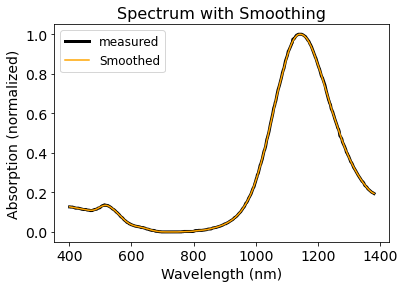

1142
401 1381
[]
starting
516 transverse peak wavelength
printing longitudinal
[621]
max post transverse
120
115
1.0
peak location = 1142
[7.6, 1142, 1.0, 516]
Guessed AR 7.6
setting peaks
401
401 1381
[0, 981, 'Red']
Starting
[0, 981, 'Red'] peak indicies


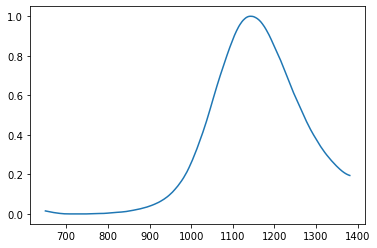

comparision peak indicies
[249, 981, 'Red']
650 1381
650 1382
len_dia_correlation
([50, 2.5, 6.58, 0.658, 0.4], [50, 5, 6.58, 0.658, 0.4], [50, 10, 6.58, 1.316, 0.4], [100, 5, 13.16, 1.316, 0.4], [100, 10, 13.16, 1.316, 0.4], [100, 20, 13.16, 2.632, 0.4], [150, 7.5, 19.74, 1.974, 0.4], [150, 15, 19.74, 1.974, 0.4], [150, 30, 19.74, 3.948, 0.4])
[4.6, 9]
['bounds =', ([12, 1, 6, 0.5, 0.2], [180, 50, 50, 20, 0.8])]
True
Calculating true distributions from population matrix
[58.87506671445565, 8.800084965871104, 8.26477075761498, 1.621209151069145, 7.401502348908523, 0.9016363275844997]
reduced chisq = 0.20544618601429437
hit bound = False
1
True
Calculating true distributions from population matrix
[54.893314215453856, 3.2968923410547775, 7.548148450392211, 0.9612409023478088, 7.405101937338585, 0.8468045203106914]
reduced chisq = 0.28087328516943194
hit bound = False
2
True
Calculating true distributions from population matrix
[58.8753500980717, 8.80013574799027, 8.264804957118768, 1.62

In [21]:
Decon_obj = Absorption_decon(Test_spectra[len(Test_spectra)-79], smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
                                         show_sim = False, blue_edge_location = 650, smoothing_parameters = [51,3]) 
output_object_first = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
                                                   simulation_baseline = True, show_distributions = False, 
                                                   rebaseline_spectrum = True, store_fits = True)

In [14]:
# output_object_first.fit_results

(46, 491, 1299)
Katherinne_Requejo_2018_Figure_6_Red


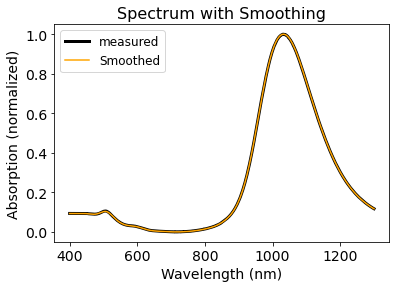

1032
401 1300
[]
starting
504 transverse peak wavelength
printing longitudinal
[523]
max post transverse
108
103
1.0
peak location = 1032
[6.442105263157894, 1032, 1.0, 504]
Guessed AR 6.442105263157894
setting peaks
401
401 1300
[0, 900, 'Red']
Starting
[0, 900, 'Red'] peak indicies


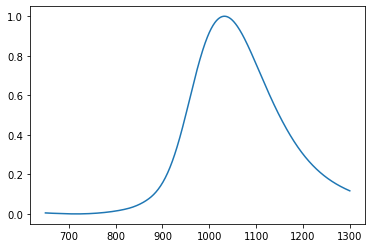

comparision peak indicies
[249, 900, 'Red']
650 1300
650 1301
len_dia_correlation
([50, 2.5, 7.76, 0.776, 0.4], [50, 5, 7.76, 0.776, 0.4], [50, 10, 7.76, 1.552, 0.4], [100, 5, 15.52, 1.552, 0.4], [100, 10, 15.52, 1.552, 0.4], [100, 20, 15.52, 3.104, 0.4], [150, 7.5, 23.28, 2.3280000000000003, 0.4], [150, 15, 23.28, 2.3280000000000003, 0.4], [150, 30, 23.28, 4.656000000000001, 0.4])
[3.4, 9]
['bounds =', ([12, 1, 6, 0.5, 0.2], [180, 50, 50, 20, 0.8])]
True
Calculating true distributions from population matrix
[87.06088968168123, 6.529019620786189, 14.225333863437651, 2.7205976561542613, 6.267682246159402, 0.9224760908115246]
reduced chisq = 0.656174286015489
hit bound = False
1
True
Calculating true distributions from population matrix
[87.06293011082674, 6.529082017038396, 14.225716214521627, 2.7206742124944534, 6.267661864352224, 0.9224789553735873]
reduced chisq = 0.6561742689182782
hit bound = False
2
True
Calculating true distributions from population matrix
[87.06456228445096, 6.5

In [24]:
Decon_obj = Absorption_decon(Test_spectra[79], smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
                             show_sim = False, blue_edge_location = 650, smoothing_parameters = (51, 3)) 
output_object_first = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
                                       simulation_baseline = True, show_distributions = False, 
                                       rebaseline_spectrum = True, store_fits = True)

In [ ]:
# a series of example plots used in figure 4

In [25]:
lengths = []
steps = []
count = 0
for i in range(0, len(output_object_first.fit_results['len_dia_correlation'][0][1][1][6])):
    lengths.append(output_object_first.fit_results['len_dia_correlation'][0][1][1][6][i][0])
    steps.append(count)
    count += 1

In [26]:
lengths2 = []
steps2 = []
count = 0
for i in range(0, len(output_object_first.fit_results['len_dia_correlation'][0][1][4][6])):
    lengths2.append(output_object_first.fit_results['len_dia_correlation'][0][1][4][6][i][0])
    steps2.append(count)
    count += 1

In [27]:
lengths3 = []
steps3 = []
count = 0
for i in range(0, len(output_object_first.fit_results['len_dia_correlation'][0][1][7][6])):
    lengths3.append(output_object_first.fit_results['len_dia_correlation'][0][1][7][6][i][0])
    steps3.append(count)
    count += 1

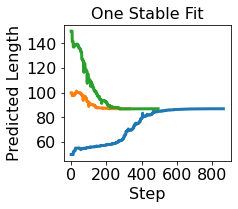

In [28]:
plt.figure(figsize=(3, 2.5))
plt.plot(steps, lengths, linewidth = 3)
plt.plot(steps2, lengths2, linewidth = 3)
plt.plot(steps3, lengths3, linewidth = 3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.axhline(y=57.5, color='r', linestyle='-', linewidth = 2)
plt.title("One Stable Fit", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.ylabel("Predicted Length", fontsize=16)
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_3_One_stable_fit.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

(46, 491, 1299)
Katherinne_Requejo_2018_Figure_3B_Blue


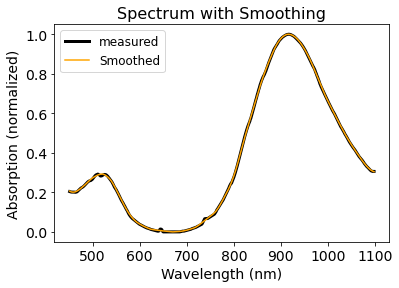

916.0
451.0 1098.0
[20]
520
printing longitudinal
[391]
max post transverse
74
69
1.0
peak location = 916.0
[5.221052631578948, 916.0, 1.0, 520]
Guessed AR 5.221052631578948
setting peaks
451.0
451.0 1098.0
[50, 698, 'Red']
Starting
[50, 698, 'Red'] peak indicies


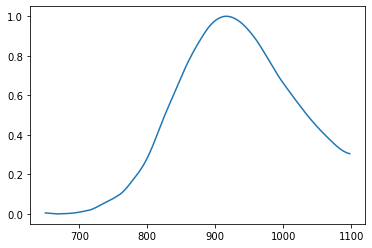

comparision peak indicies
[199, 648, 'Red']
650.0 1098.0
600 1049
[249, 698, 'Red']
printing new results
650 1099
650.0 1098.0
len_dia_correlation
([50, 2.5, 9.58, 0.9580000000000001, 0.4], [50, 5, 9.58, 0.9580000000000001, 0.4], [50, 10, 9.58, 1.9160000000000001, 0.4], [100, 5, 19.15, 1.915, 0.4], [100, 10, 19.15, 1.915, 0.4], [100, 20, 19.15, 3.83, 0.4], [150, 7.5, 28.73, 2.873, 0.4], [150, 15, 28.73, 2.873, 0.4], [150, 30, 28.73, 5.746, 0.4])
[2.2, 8.2]
['bounds =', ([12, 1, 6, 0.5, 0.2], [180, 50, 50, 20, 0.8])]
True
Calculating true distributions from population matrix
[89.14469603788729, 14.532871850875413, 18.1728687835171, 5.723356693050242, 5.191574831767502, 1.2338613576991717]
reduced chisq = 0.8138555040408868
hit bound = False
1
True
Calculating true distributions from population matrix
[89.14513254154558, 14.532893502619064, 18.172978095192633, 5.723393551072352, 5.191569242253646, 1.2338618240741153]
reduced chisq = 0.8138555037530083
hit bound = False
2
True
Calculating

In [29]:
Decon_obj = Absorption_decon(Test_spectra[74], smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
                             show_sim = False, blue_edge_location = 650, smoothing_parameters = (51, 3)) 
output_object_first = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
                                       simulation_baseline = True, show_distributions = False, 
                                       rebaseline_spectrum = True, store_fits = True)

In [30]:
lengths = []
steps = []
count = 0
for i in range(0, len(output_object_first.fit_results['len_dia_correlation'][0][1][1][6])):
    lengths.append(output_object_first.fit_results['len_dia_correlation'][0][1][1][6][i][0])
    steps.append(count)
    count += 1

In [31]:
lengths2 = []
steps2 = []
count = 0
for i in range(0, len(output_object_first.fit_results['len_dia_correlation'][0][1][4][6])):
    lengths2.append(output_object_first.fit_results['len_dia_correlation'][0][1][4][6][i][0])
    steps2.append(count)
    count += 1

In [32]:
lengths3 = []
steps3 = []
count = 0
for i in range(0, len(output_object_first.fit_results['len_dia_correlation'][0][1][7][6])):
    lengths3.append(output_object_first.fit_results['len_dia_correlation'][0][1][7][6][i][0])
    steps3.append(count)
    count += 1

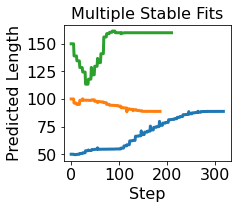

In [33]:
plt.figure(figsize=(3, 2.5))
plt.plot(steps, lengths, linewidth = 3)
plt.plot(steps2, lengths2, linewidth = 3)
plt.plot(steps3, lengths3, linewidth = 3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.axhline(y=57.5, color='r', linestyle='-', linewidth = 2)
plt.title("Multiple Stable Fits", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.ylabel("Predicted Length", fontsize=16)
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_3_multiple_stable_fits.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

(46, 491, 1299)
Long Rod


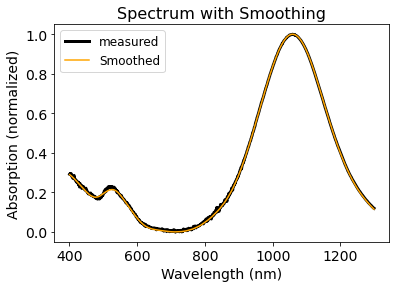

1058
401 1299
[25]
525
printing longitudinal
[528]
max post transverse
129
124
1.0
peak location = 1058
[6.71578947368421, 1058, 1.0, 525]
Guessed AR 6.71578947368421
['thresholds', 0.001, 0.12]
0.12 0.001 0.12
self.longitudinal_threshold = 0.12
Wavelength mins, must be 401 for proper comparison to simulations
401
[443, 896]


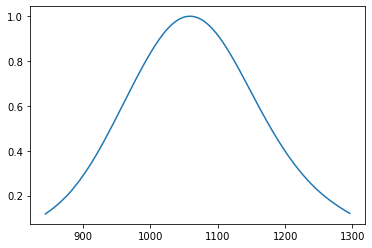

comparision peak indicies
[443, 896]
844 1296
844 1297
(46, 491, 1299)
Long Rod


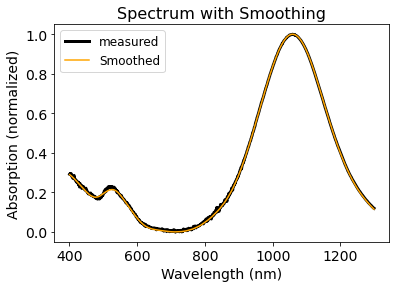

1058
401 1299
[25]
525
printing longitudinal
[528]
max post transverse
129
124
1.0
peak location = 1058
[6.71578947368421, 1058, 1.0, 525]
Guessed AR 6.71578947368421
setting peaks
401
401 1299
[0, 899, 'Red']
Starting
[0, 899, 'Red'] peak indicies


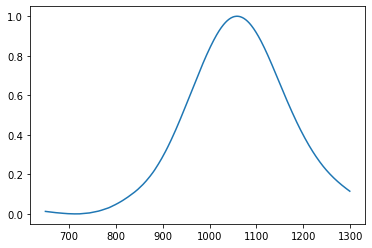

comparision peak indicies
[249, 899, 'Red']
650 1299
650 1300
len_dia_correlation_rel_std
([50, 7.45, 0.05, 0.4], [50, 7.45, 0.1, 0.4], [50, 7.45, 0.2, 0.4], [100, 14.89, 0.05, 0.4], [100, 14.89, 0.1, 0.4], [100, 14.89, 0.2, 0.4], [150, 22.34, 0.05, 0.4], [150, 22.34, 0.1, 0.4], [150, 22.34, 0.2, 0.4])
[3.7, 9]
['bounds =', ([12, 6, 0.025, 0.2], [180, 45, 0.4, 0.8])]
Calculating true distributions from population matrix
[106.11542017538575, 24.127619061021623, 18.900464870623196, 4.2931333877656295, 5.679879028616102, 0.890305672554458]
reduced chisq = 0.5589413893799353
hit bound = False
1
Calculating true distributions from population matrix
[106.11561665748636, 24.127651615500298, 18.90050832769564, 4.293141160444396, 5.679876428901816, 0.8903048135697508]
reduced chisq = 0.5589413895680526
hit bound = False
2
Calculating true distributions from population matrix
[106.11530336717519, 24.127599427388123, 18.900438986953375, 4.293128706533475, 5.679880587212634, 0.8903061735059691]
re

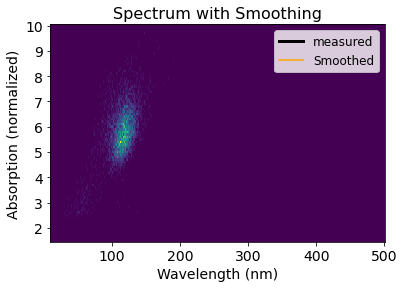

696
401 1300
[13]
513
printing longitudinal
[178]
max post transverse
117
112
1.0
peak location = 696
[2.905263157894737, 696, 1.0, 513]
Guessed AR 2.905263157894737
['thresholds', 0.19, 0.001]
0.19 0.19 0.001
self.longitudinal_threshold = 0.19
Wavelength mins, must be 401 for proper comparison to simulations
401
[192, 406]


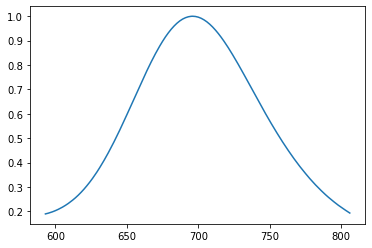

comparision peak indicies
[192, 406]
593 806
593 807


In [35]:
Test_spectra = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/Wang/*.csv')
Test_spectra = Test_spectra[0:len(Test_spectra)]
for spectrum in Test_spectra:
    run_fit_on_all(spectrum, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/new indexing test/', smoothing_params = [101,3])

In [ ]:
# load and process output files for the literature mined unlabeled spectra 

In [36]:
output_files_unlabeled = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/unlabeled_spectra_fits/*.joblib')

In [37]:
print(len(output_files_unlabeled))

115


In [38]:
cutoff = 790
output_files_for_analysis = []
for file in output_files_unlabeled:
    # print(file)
    output_file = joblib.load(file)
    if type(output_file) != list: 
        print(output_file.name)
        if 'Clean' in file or 'Rod' in file or 'nimbus' in file:
            temp = output_file.tabulate_results()[0][2]
            true_values = []
            temp_val = ''
            for char in temp[11:len(temp)]:
                if char not in '()':
                    temp_val += char
                if char in '()':
                    true_values.append(float(temp_val))
                    temp_val = ''
            output_file.true_values = true_values
            print(output_file.true_values)
        if output_file.smoothed_spectrum[len(output_file.smoothed_spectrum)-1] < 0.5:

            if 'Zhang_2021' not in file: 
            # if 'Zhang_2014_Figure_S10_Blue' in file:
                smoothed_spectrum = savgol_filter(output_file.inputted_spectrum, output_file.smoothing_parameters[0], output_file.smoothing_parameters[1])
                inten_max = max(smoothed_spectrum)
                peak_loc = list(smoothed_spectrum).index(inten_max)
                wavelength_loc = output_file.wavelengths[peak_loc]
                if wavelength_loc > cutoff+5:
                    try: 
                        # if float(output_file.true_values[2]) > 6: 
                        print(output_file.name)
                        print(output_file.true_values)
                        print(output_file.output_table)
                        print('passed filtering')
                        output_files_for_analysis.append(output_file)
                    except TypeError:
                        pass

Catherine J
Catherine J
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', 'Failed Fit, all fits hit bounds']]
passed filtering
Hao_Huang_2018_Figure_s1a_red
Huei-Huei_Chang_2018_Figure_S1_Purple
Huei-Huei_Chang_2018_Figure_S1_Purple
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', '33.3(6.6) 9.3(0.5) 3.6(0.7)']]
passed filtering
Huei-Huei_Chang_2018_Figure_S3_Green
Huei-Huei_Chang_2018_Figure_S3_Green
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', '91.4(30.3) 31.0(4.8) 3.1(0.9)']]
passed filtering
Huei-Huei_Chang_2018_Figure_S4_Green
Katherinne I
Katherinne I
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', '65.5(30.5) 19.2(2.7) 3.5(1.1)']]
passed filtering
Leonid_Vigderman_2013_Figure_8A_LBlue
Leonid_Vigderman_2013_Figure_8A_LBlue
[]
[['Model Type', 'Overlap', 'Prediction

Wang_2016_Figure_5_Blue
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', 'Failed Fit, all fits hit bounds']]
passed filtering
Wang_2016_Figure_5_Pink
Wang_2016_Figure_5_Pink
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', '45.6(8.1) 9.9(0.6) 4.6(0.6)']]
passed filtering
Wang_2016_Figure_5_Red
Wang_2016_Figure_5_Red
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', '64.7(7.7) 13.8(0.7) 4.7(0.6)']]
passed filtering
Wang_2016_Figure_6_Blue
Wang_2016_Figure_6_Blue
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', 'Failed Fit, all fits hit bounds']]
passed filtering
Wang_2016_Figure_6_Teal
Wang_2016_Figure_6_Teal
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation', 'NA', 'Failed Fit, all fits hit bounds']]
passed filtering
Wang_2016_Fig

Zhang_2014_Figure_3_Lavender
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation_rel_std', 'NA', '46.0(7.0) 7.5(1.1) 6.3(0.9)']]
passed filtering
Zhang_2014_Figure_3_Magenta
Zhang_2014_Figure_3_Magenta
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation_rel_std', 'NA', '44.1(8.5) 8.1(1.5) 5.6(1.0)']]
passed filtering
Zhang_2014_Figure_3_Maroon
Zhang_2014_Figure_3_Maroon
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation_rel_std', 'NA', '41.5(7.4) 7.9(1.4) 5.4(0.9)']]
passed filtering
Zhang_2014_Figure_3_Navy
Zhang_2014_Figure_3_Navy
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation_rel_std', 'NA', '35.4(4.8) 7.2(1.0) 5.1(0.9)']]
passed filtering
Zhang_2014_Figure_S10_Black
Zhang_2014_Figure_S10_Black
[]
[['Model Type', 'Overlap', 'Predictions nan(nan) nan(nan) nan(nan)'], ['len_dia_correlation_rel_std', 'NA', '36.

In [39]:
len(output_files_for_analysis)

97

In [ ]:
# visualize dataset spread for literature mined spectra

In [40]:
length_means = []
length_stds = []
dia_means = []
dia_stds = []
ar_means = []
ar_stds = []

for file in output_files_for_analysis:
    if file.output_table[1][2][0:6] != 'Failed':
        out_list = []
        for i in file.output_table[1][2].split():
            out_list.append(float(i.split('(')[0]))
            out_list.append(float(i.split('(')[1][0:3]))
        length_means.append(out_list[0])
        length_stds.append(out_list[1])
        dia_means.append(out_list[2])
        dia_stds.append(out_list[3])
        ar_means.append(out_list[4])
        ar_stds.append(out_list[5])


In [41]:
print(len(length_means))

64


In [42]:
# plots in figure 3 i-l

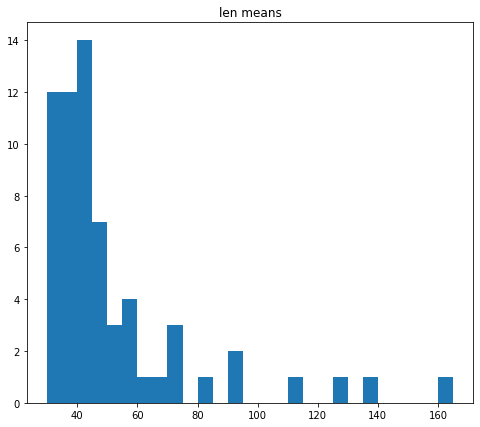

In [43]:
plt.figure(figsize=(8,7))
plt.hist(length_means, bins = np.linspace(30,165,28))
plt.title('len means')
plt.rcParams['pdf.fonttype'] = 'truetype'
# plt.savefig('Fig_5_unlabeled_len_dist.pdf', bbox_inches = 'tight', transparent = True)

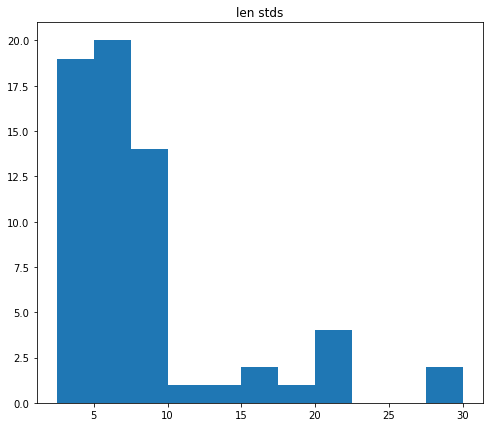

In [44]:
plt.figure(figsize=(8,7))
plt.hist(length_stds, bins = np.linspace(2.5,30,12))
plt.title('len stds')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_5_unlabeled_len_std_dist.pdf', bbox_inches = 'tight', transparent = True)

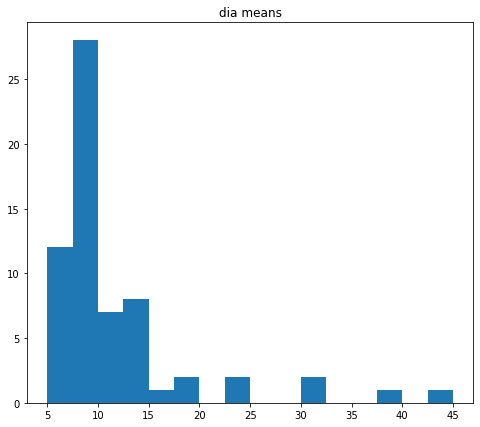

In [45]:
plt.figure(figsize=(8,7))
plt.hist(dia_means, bins = np.linspace(5,45,17))
plt.title('dia means')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_5_unlabeled_dia_dist.pdf', bbox_inches = 'tight', transparent = True)

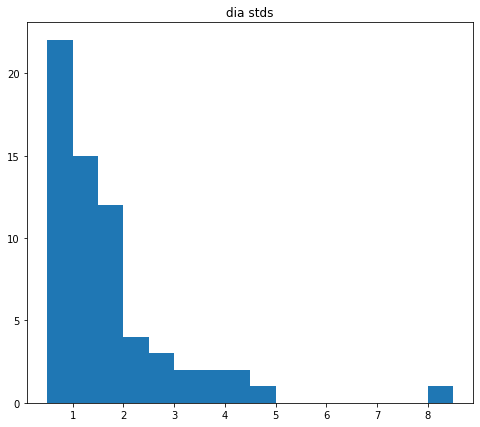

In [46]:
plt.figure(figsize=(8,7))
plt.hist(dia_stds, bins = np.linspace(0.5, 8.5, 17))
plt.title('dia stds')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_5_unlabeled_dia_std_dist.pdf', bbox_inches = 'tight', transparent = True)

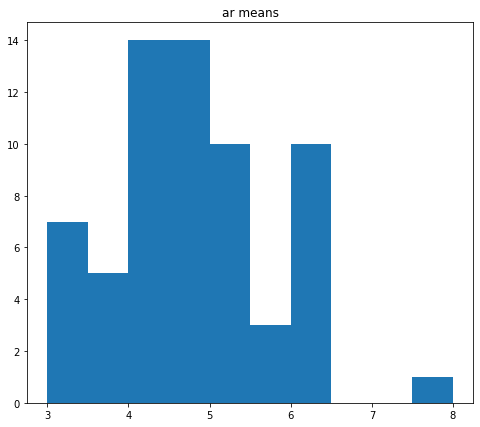

In [47]:
plt.figure(figsize=(8,7))
plt.hist(ar_means, bins = np.linspace(3, 8, 11))
plt.title('ar means')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_5_unlabeled_ar_dist.pdf', bbox_inches = 'tight', transparent = True)

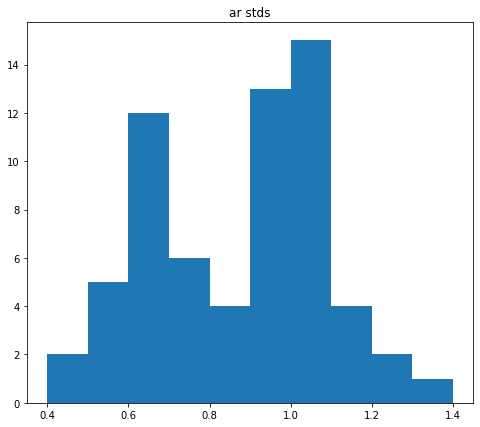

In [48]:
plt.figure(figsize=(8,7))
plt.hist(ar_stds, bins = np.linspace(0.4,1.4, 11))
plt.title('ar stds')
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_5_unlabeled_ar_std_dist.pdf', bbox_inches = 'tight', transparent = True)

In [ ]:
# load and process output files for the validation data

In [49]:
# output_files = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/800 nm on true vals test/*.joblib')
output_files = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/PAPER FILES 790 nm on processed/790 nm on with true vals/*.joblib')
# output_files = glob.glob("C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/040424_validation/790 nm on with true vals/*.joblib")

In [50]:
output_file = joblib.load(output_files[12])

In [51]:
output_file.tabulate_results(overlap_method='lit') # example of fit validation comparison

╒═════════════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 48.4(9.6) 6.0(0.7) 8.2(2.3)   │
╞═════════════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.494124 │ 42.3(5.3) 6.9(0.9) 6.4(1.0)               │
╘═════════════════════════════╧═══════════╧═══════════════════════════════════════════╛


[['Model Type', 'Overlap', 'Predictions 48.4(9.6) 6.0(0.7) 8.2(2.3)'],
 ['len_dia_correlation_rel_std',
  0.49412448799711284,
  '42.3(5.3) 6.9(0.9) 6.4(1.0)']]

In [53]:
cutoff = 790
output_files_for_analysis = []
count_incomplete = 0
count_too_close_to_threshold = 0
count_too_low_diameter = 0

for file in output_files:
    output_file = joblib.load(file)
    
    if type(output_file) != list: 
        # print(output_file.name)
        # if 'Clean' in file or 'Rod' in file or 'nimbus' in file:
        temp = output_file.tabulate_results(show_table = False, overlap_method='lit')[0][2]
        true_values = []
        temp_val = ''
        for char in temp[11:len(temp)]:
            if char not in '()':
                temp_val += char
            if char in '()':
                true_values.append(float(temp_val))
                temp_val = ''
        output_file.true_values = true_values
            # print(output_file.true_values)
        if output_file.smoothed_spectrum[len(output_file.smoothed_spectrum)-1] < 0.5:

            # if 'Zhang_2021' not in file: 
            smoothed_spectrum = savgol_filter(output_file.inputted_spectrum, output_file.smoothing_parameters[0], output_file.smoothing_parameters[1])
            inten_max = max(smoothed_spectrum)
            peak_loc = list(smoothed_spectrum).index(inten_max)
            wavelength_loc = output_file.wavelengths[peak_loc]
            if wavelength_loc >= cutoff+5:
                try: 
                    if float(output_file.true_values[2]) > 6: 
                        # print(output_file.name)
                        # print(output_file.true_values)
                        print(output_file.name + ' passed filtering')
                        output_files_for_analysis.append(output_file)
                    else:
                        count_too_low_diameter += 1 
                        print(output_file.name + ' too low dia')

                except TypeError:
                    pass
            else:
                count_too_close_to_threshold += 1 
                print(output_file.name + ' too close to threshold')

        else:
            count_incomplete += 1 
            print(output_file.name + ' incomplete')
            
print(str(count_incomplete) + ' incomplete')
print(str(count_too_close_to_threshold) + ' too close to threshold')
print(str(count_too_low_diameter) + ' too low dia')

A11_Post_Clean passed filtering
A12_Post_Clean passed filtering
A7_Post_Clean passed filtering
B2_Post_Clean passed filtering
B3_Post_Clean passed filtering
B4_Pre_Clean_sonic_0720 passed filtering
B8_Post_Clean passed filtering
C2_nimbus_051221 passed filtering
C4_nimbus_052621 passed filtering
C4_Post_Clean passed filtering
C7_Post_Clean passed filtering
Chang_2018_Figure_2_Orange too close to threshold
Chang_2018_Figure_3_Blue too low dia
Chang_2018_Figure_3_Green incomplete
Chang_2018_Figure_3_Pink incomplete
Chang_2018_Figure_3_Red too low dia
Chang_2018_Figure_3_Yellow incomplete
Chang_2018_Figure_S2_Blue incomplete
Chang_2018_Figure_S2_Orange incomplete
D12_Post_Clean_sonic_071621 passed filtering
D1_nimbus_051221 passed filtering
D2_nimbus_051221 passed filtering
D4_Post_Clean passed filtering
Dopamine Bottom Fig panel 3 corrected passed filtering
F12_Post_Clean_sonic_071621 passed filtering
G3_nimbus_052621 passed filtering
G4_Post_Clean passed filtering
Gallagher_2020_Figure_

In [54]:
for obj in output_files_for_analysis:
    try:
        if type(obj.fit_results['len_dia_correlation'][0][0]) == str:
            print(obj.fit_results['len_dia_correlation'][0][0])
            print(obj.name)
    except KeyError:
        pass

In [ ]:
# load object that conducts analysis on the literature and high throughput labeled data 

In [55]:
test_spectra_obj = test_spectra_fit('test', 'test', output_files_for_analysis)

41
A11_Post_Clean
[37.48730451256067, 5.443035373787867, 7.541878412391414, 1.0795720761916123, 5.133095369288563, 0.9676087782144934]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A12_Post_Clean
[44.21794939366498, 6.714017978817783, 7.759566744588762, 1.1610179842275254, 5.864538660679826, 1.0773404296995737]
A12_Post_Clean
[44.6, 13.8, 12.0, 3.9, 3.8, 1.3]
A7_Post_Clean
[39.33177650110443, 6.7351457033462445, 8.087464865471912, 1.3520252651421836, 5.049333475690844, 1.1248736715845475]
A7_Post_Clean
[36.8, 12.0, 11.9, 3.8, 3.2, 1.1]
B2_Post_Clean
[33.18301075509079, 2.440624299916157, 7.924127647418337, 1.6183902827532735, 4.534148540180841, 0.8235771616933435]
B2_Post_Clean
[40.2, 12.2, 11.1, 3.6, 3.7, 1.0]
B3_Post_Clean
[33.23742420048989, 2.694172991928731, 7.371844142903978, 1.2177739866680959, 4.824896111690947, 0.8336035275976152]
B3_Post_Clean
[48.3, 17.7, 12.6, 5.1, 3.9, 1.0]
B4_Pre_Clean_sonic_0720
[86.4372292081892, 3.086986144412498, 18.7976536165706, 2.691120561726342

In [ ]:
# plots that make figure 2 e-i

                                                         0      1
A11_Post_Clean                                       37.50   37.5
A12_Post_Clean                                       44.60   44.2
A7_Post_Clean                                        36.80   39.3
B2_Post_Clean                                        40.20   33.2
B3_Post_Clean                                        48.30   33.2
B4_Pre_Clean_sonic_0720                              54.70   86.4
B8_Post_Clean                                        37.10   36.5
C2_nimbus_051221                                     33.70   28.3
C4_nimbus_052621                                     35.30   37.9
C4_Post_Clean                                        67.10   84.0
C7_Post_Clean                                        35.70   36.9
D12_Post_Clean_sonic_071621                          39.90   34.1
D1_nimbus_051221                                     31.10   47.1
D2_nimbus_051221                                     30.40   45.2
D4_Post_Cl

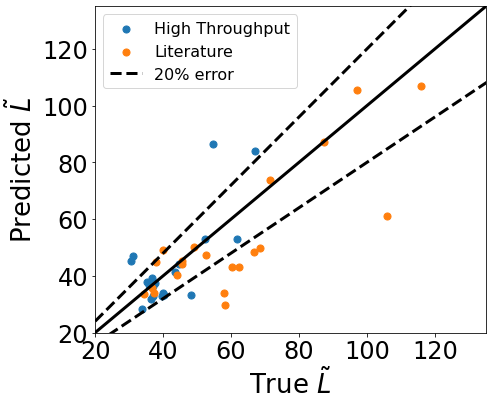

0.5509032790551178
9.03048780487805


In [146]:
# test_spectra_obj = test_spectra_fit('test', 'test', output_files_for_analysis)
plt.rcParams['pdf.fonttype'] = 'truetype'
test_spectra_obj.r_squared('len_mean')
# test_spectra_obj.r_squared('len_mean')
# 9.03048780487805

                                                        0     1
A11_Post_Clean                                      12.20   5.4
A12_Post_Clean                                      13.80   6.7
A7_Post_Clean                                       12.00   6.7
B2_Post_Clean                                       12.20   2.4
B3_Post_Clean                                       17.70   2.7
B4_Pre_Clean_sonic_0720                             20.10   3.1
B8_Post_Clean                                       13.60   5.5
C2_nimbus_051221                                     9.40   4.2
C4_nimbus_052621                                    10.00   9.6
C4_Post_Clean                                       17.50  13.4
C7_Post_Clean                                       13.90   6.3
D12_Post_Clean_sonic_071621                         15.30   4.7
D1_nimbus_051221                                     9.70  10.4
D2_nimbus_051221                                     8.90   6.8
D4_Post_Clean                           

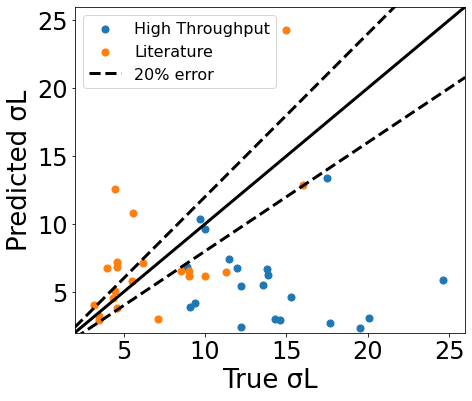

-1.0113005917253033
5.501951219512195


In [142]:
plt.rcParams['pdf.fonttype'] = 'truetype'
test_spectra_obj.r_squared('len_std')
# 5.501951219512195

                                                           0    1
A11_Post_Clean                                      3.800000  5.1
A12_Post_Clean                                      3.800000  5.9
A7_Post_Clean                                       3.200000  5.0
B2_Post_Clean                                       3.700000  4.5
B3_Post_Clean                                       3.900000  4.8
B4_Pre_Clean_sonic_0720                             4.300000  4.7
B8_Post_Clean                                       3.500000  5.0
C2_nimbus_051221                                    4.000000  4.4
C4_nimbus_052621                                    4.100000  4.4
C4_Post_Clean                                       3.600000  4.4
C7_Post_Clean                                       3.800000  4.9
D12_Post_Clean_sonic_071621                         4.400000  4.8
D1_nimbus_051221                                    3.500000  4.1
D2_nimbus_051221                                    3.800000  4.3
D4_Post_Cl

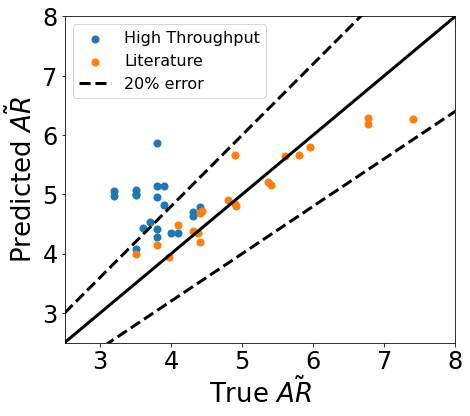

0.2700413415528592
0.6364227560975609


In [143]:
plt.rcParams['pdf.fonttype'] = 'truetype'
test_spectra_obj.r_squared('ar_mean')
# 0.636422756097561

                                                       0    1
A11_Post_Clean                                      1.20  1.0
A12_Post_Clean                                      1.30  1.1
A7_Post_Clean                                       1.10  1.1
B2_Post_Clean                                       1.00  0.8
B3_Post_Clean                                       1.00  0.8
B4_Pre_Clean_sonic_0720                             1.10  0.7
B8_Post_Clean                                       1.10  1.0
C2_nimbus_051221                                    1.00  0.9
C4_nimbus_052621                                    0.90  0.8
C4_Post_Clean                                       0.70  0.9
C7_Post_Clean                                       1.20  1.1
D12_Post_Clean_sonic_071621                         1.00  0.8
D1_nimbus_051221                                    0.90  1.0
D2_nimbus_051221                                    1.00  0.8
D4_Post_Clean                                       0.70  0.9
Dopamine

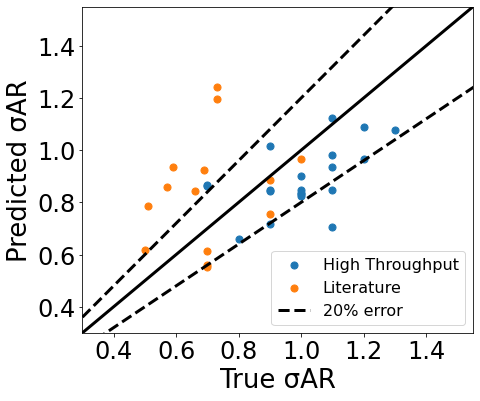

-0.05931690180541627
0.18105715481256474


In [144]:
plt.rcParams['pdf.fonttype'] = 'truetype'
test_spectra_obj.r_squared('ar_std')
# 0.18105873697507513

mean overlap = 0.3022821951603981
std overlap = 0.20458640825422972
median overlap = 0.2924448589433356


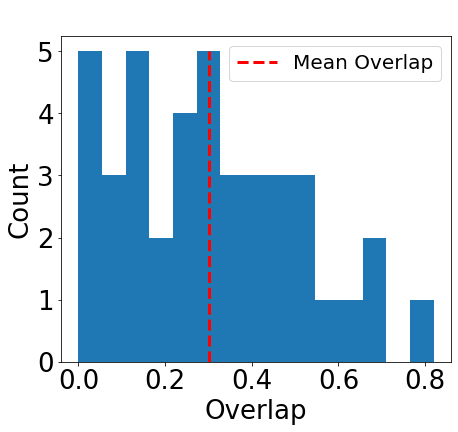

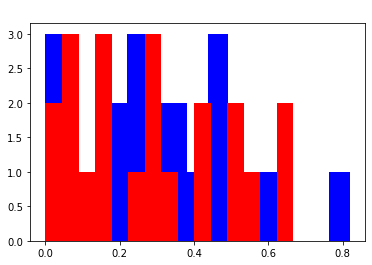

[0.3022821951603981,
 0.20458640825422972,
 0.2924448589433356,
 [0.29689306436947416,
  0.23673259805234267,
  0.30233561397089387,
  0.15471652958533658,
  0.0696901586367631,
  0.06661285083251416,
  0.2662255803395093,
  0.3489090651879442,
  0.6557917011230116,
  0.4927904642998012,
  0.41693673227744976,
  0.18861583250015956,
  0.3103293429124491,
  0.22791344648414608,
  0.14332034085308978,
  0.5403575616789971,
  0.339224096092043,
  0.1287120364203555,
  0.07611112002146624,
  0.18993882139304752,
  0.14788036709122548,
  0.4362539924551275,
  0.6200748074344102,
  0.4520140647084548,
  0.44048045361399124,
  0.451585271374082,
  0.8195671386827956,
  6.711032345589492e-05,
  0.2480884454969661,
  0.6009887948970287,
  0.4065843141294675,
  0.2924448589433356,
  1.1881901667190026e-05,
  0.14062714066601226,
  0.5083304125655258,
  0.667951387390939,
  0.2802063181826636,
  0.3677552528566186,
  0.01875404931231385,
  5.177007109066299e-05,
  0.04169521244835854],
 ['A11_Pos

In [61]:
plt.rcParams['pdf.fonttype'] = 'truetype'
test_spectra_obj.visualize_overlaps(hist_title = ' ', overlap_method = 'lit')
# 0.3022752258931717

In [65]:
# example for AR std - stops at -7th index due to the lack of data for the last seven values. Remove this for other 
# size parameters
true_param = np.asarray(test_spectra_obj.predicted_ar_stds)[0]
pred_param = np.asarray(test_spectra_obj.true_ar_stds)
mean_param_percent_error = np.mean(np.abs(true_param[0:len(pred_param)-7] - pred_len[0:len(pred_param)-7])/true_param[0:len(pred_param)-7])

In [66]:
np.mean(np.abs(true_param - pred_param)[0:len(pred_param)-7])

0.17999999999999997

In [67]:
mean_param_percent_error

0.20977792632204398

In [223]:
# mean error across size params
mean_errors_by_param = [8.9, 5.4, 0.64, 0.18]
percent_errors_by_param = [0.2, 1.3, 0.13, 0.21]

In [ ]:
# Figure 4 example figures

(46, 491, 1299)
Chang_2018_Figure_3_Pink


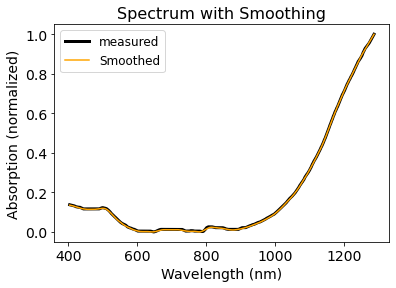

1288.0
404.0 1288.0
[]
starting
500.0 transverse peak wavelength
printing longitudinal
[]
max post transverse
101
96
1.0
peak location = 1288.0
[9.136842105263158, 1288.0, 1.0, 500.0]
Guessed AR 9.136842105263158
['thresholds', 0.001, 1.01]
0.001 0.001 1.01
self.longitudinal_threshold = 0.001
Wavelength mins, must be 401 for proper comparison to simulations
404.0
[380, 885]


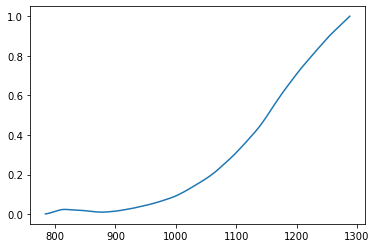

comparision peak indicies
[380, 885]
784.0 1288.0
781 1286
[383, 888]
printing new results
784 1289
784.0 1288.0


In [68]:
Test_spectra = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/All Spectra Corrected 11_23/*.csv')
# for i in range(0, len(Test_spectra)):
Decon_obj = Absorption_decon(Test_spectra[6], smooth_spectrum = True, pick_longitudinal = True, 
                                 blue_baseline = False, show_sim = False, smoothing_parameters = [51,3], 
                                 min_longitudinal_threshold = 0.001)

Chang_2018_Figure_3_Pink


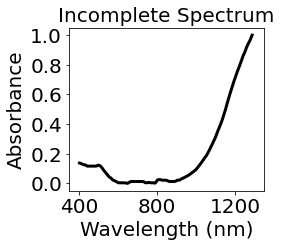

In [69]:
try: 
    # if float(file.true_values[2]) > 6: 
    print(Decon_obj.name)
    plt.figure(figsize=(3.5, 3.0))
    plt.plot(Decon_obj.inputted_wavelengths[0:len(Decon_obj.inputted_wavelengths)], 
             Decon_obj.inputted_intens[0:len(Decon_obj.inputted_wavelengths)]/max(Decon_obj.inputted_intens[0:len(Decon_obj.inputted_wavelengths)]), linewidth = 3, color = 'k')
    plt.title('Incomplete Spectrum', fontsize = 20)
    plt.xlabel("Wavelength (nm)", fontsize=20)
    plt.ylabel("Absorbance", fontsize=20)
    # plt.legend(fontsize = 12)
    plt.xlim([350, 1350])
    plt.xticks([400, 800, 1200], fontsize=20)
    plt.yticks(fontsize=20)
    plt.rcParams['pdf.fonttype'] = 'truetype'
    plt.savefig('Incomplete Spectrum.pdf', bbox_inches = 'tight', transparent=True)
    plt.show()
except TypeError:
    print(file.name)


(46, 491, 1299)
Chang_2018_Figure_2_Blue


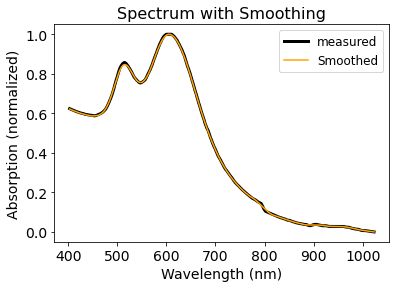

605.0
403.0 1023.0
[15]
515
printing longitudinal
[85]
max post transverse
117
112
1.0
peak location = 605.0
[1.9473684210526316, 605.0, 1.0, 515]
Guessed AR 1.9473684210526316
['thresholds', 0.6, 0.001]
0.6 0.6 0.001
self.longitudinal_threshold = 0.6
Wavelength mins, must be 401 for proper comparison to simulations
403.0
[65, 270]


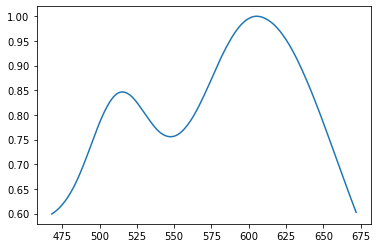

comparision peak indicies
[65, 270]
468.0 672.0
466 671
[67, 272]
printing new results
468 673
468.0 672.0


In [70]:
Test_spectra = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Spectra_to_predict/All Spectra Corrected 11_23/*.csv')

Decon_obj = Absorption_decon(Test_spectra[0], smooth_spectrum = True, pick_longitudinal = True, 
                                 blue_baseline = False, show_sim = False, smoothing_parameters = [51,3], 
                                 min_longitudinal_threshold = 0.001)

Chang_2018_Figure_2_Blue


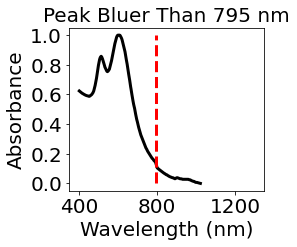

In [71]:
try: 
    # if float(file.true_values[2]) > 6: 
    print(Decon_obj.name)
    plt.figure(figsize=(3.5, 3.0))
    plt.plot(Decon_obj.inputted_wavelengths[0:len(Decon_obj.inputted_wavelengths)], 
             Decon_obj.inputted_intens[0:len(Decon_obj.inputted_wavelengths)]/max(Decon_obj.inputted_intens[0:len(Decon_obj.inputted_wavelengths)]), linewidth = 3, color = 'k')
    plt.vlines(795, 0,1, linestyle = '--', label = 'Cutoff', linewidth = 3, color = 'r')
    plt.title('Peak Bluer Than 795 nm', fontsize = 20)
    plt.xlabel("Wavelength (nm)", fontsize=20)
    plt.ylabel("Absorbance", fontsize=20)
    # plt.legend(fontsize = 12)
    plt.xlim([350, 1350])
    plt.xticks([400, 800, 1200], fontsize=20)
    plt.yticks(fontsize=20)
    plt.rcParams['pdf.fonttype'] = 'truetype'
    plt.savefig('Peak Bluer Than 795 nm.pdf', bbox_inches = 'tight', transparent=True)
    plt.show()
except TypeError:
    print(file.name)


D1_nimbus_051221


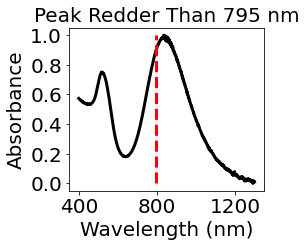

In [72]:
count = 0
for file in output_files_for_analysis:
    # print(count)
    # if count > 1:
        # break
    if type(file) != list:
        count += 1
        # if file.inputted_spectrum[len(file.inputted_spectrum)-1] < 0.5:
            # if 'Zhang_2021' not in file.name: 
        if file.name == 'D1_nimbus_051221':
        # if file.name == 'Long Rod':
            try: 
                # if float(file.true_values[2]) > 6: 
                print(file.name)
                plt.figure(figsize=(3.5, 3.0))
                plt.plot(file.wavelengths[0:len(file.wavelengths)], file.inputted_spectrum[0:len(file.wavelengths)]/max(file.inputted_spectrum[0:len(file.wavelengths)]), linewidth = 3, color = 'k')
                plt.vlines(795, 0,1, linestyle = '--', label = 'Cutoff', linewidth = 3, color = 'r')
                plt.title('Peak Redder Than 795 nm', fontsize = 20)
                plt.xlabel("Wavelength (nm)", fontsize=20)
                plt.ylabel("Absorbance", fontsize=20)
                # plt.legend(fontsize = 12)
                plt.xlim([350, 1350])
                plt.xticks([400, 800, 1200], fontsize=20)
                plt.yticks(fontsize=20)
                plt.rcParams['pdf.fonttype'] = 'truetype'
                plt.savefig('Peak Redder Than 795 nm.pdf', bbox_inches = 'tight', transparent=True)
                plt.show()
            except TypeError:
                print(file.name)


D1_nimbus_051221


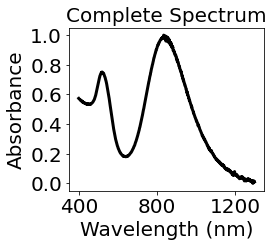

In [73]:
count = 0
for file in output_files_for_analysis:
    # print(count)
    # if count > 1:
        # break
    if type(file) != list:
        count += 1
        # if file.inputted_spectrum[len(file.inputted_spectrum)-1] < 0.5:
            # if 'Zhang_2021' not in file.name: 
        if file.name == 'D1_nimbus_051221':
        # if file.name == 'Long Rod':
            try: 
                # if float(file.true_values[2]) > 6: 
                print(file.name)
                plt.figure(figsize=(3.5, 3.0))
                plt.plot(file.wavelengths[0:len(file.wavelengths)], file.inputted_spectrum[0:len(file.wavelengths)]/max(file.inputted_spectrum[0:len(file.wavelengths)]), linewidth = 3, color = 'k')
                # plt.vlines(790, 0,1, linestyle = '--', label = 'Cutoff', linewidth = 3, color = 'r')
                plt.title('Complete Spectrum', fontsize = 20)
                plt.xlabel("Wavelength (nm)", fontsize=20)
                plt.ylabel("Absorbance", fontsize=20)
                # plt.legend(fontsize = 12)
                plt.xlim([350, 1350])
                plt.xticks([400, 800, 1200], fontsize=20)
                plt.yticks(fontsize=20)
                plt.rcParams['pdf.fonttype'] = 'truetype'
                plt.savefig('Complete Spectrum.pdf', bbox_inches = 'tight', transparent=True)

                plt.show()
            except TypeError:
                print(file.name)

Long Rod


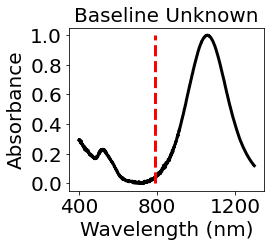

In [74]:
count = 0
for file in output_files_for_analysis:
    # print(count)
    # if count > 1:
        # break
    if type(file) != list:
        count += 1
        # if file.inputted_spectrum[len(file.inputted_spectrum)-1] < 0.5:
            # if 'Zhang_2021' not in file.name: 
        # if Decon_obj.name == 'Zhang_2021_Figure_S2_Blue':
        if file.name == 'Long Rod':
            # if float(file.true_values[2]) > 6: 
            print(file.name)
            plt.figure(figsize=(3.5, 3.0))
            plt.plot(file.wavelengths[0:len(file.wavelengths)], file.inputted_spectrum[0:len(file.wavelengths)]/max(file.inputted_spectrum[0:len(file.wavelengths)]), linewidth = 3, color = 'k')
            # plt.vlines(790, 0,1, linestyle = '--', label = 'Cutoff', linewidth = 3, color = 'r')
            plt.title('Baseline Unknown', fontsize = 20)
            plt.vlines(790, 0,1, linestyle = '--', label = 'Cutoff', linewidth = 3, color = 'r')

            plt.xlabel("Wavelength (nm)", fontsize=20)
            plt.ylabel("Absorbance", fontsize=20)
            # plt.legend(fontsize = 12)
            plt.xlim([350, 1350])
            plt.xticks([400, 800, 1200], fontsize=20)
            plt.yticks(fontsize=20)
            plt.rcParams['pdf.fonttype'] = 'truetype'
            plt.savefig('Baseline Unknown.pdf', bbox_inches = 'tight', transparent=True)
            plt.show()



In [75]:
test_spectra_obj = test_spectra_fit('test', 'test', output_files_for_analysis)

41
A11_Post_Clean
[37.48730451256067, 5.443035373787867, 7.541878412391414, 1.0795720761916123, 5.133095369288563, 0.9676087782144934]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A12_Post_Clean
[44.21794939366498, 6.714017978817783, 7.759566744588762, 1.1610179842275254, 5.864538660679826, 1.0773404296995737]
A12_Post_Clean
[44.6, 13.8, 12.0, 3.9, 3.8, 1.3]
A7_Post_Clean
[39.33177650110443, 6.7351457033462445, 8.087464865471912, 1.3520252651421836, 5.049333475690844, 1.1248736715845475]
A7_Post_Clean
[36.8, 12.0, 11.9, 3.8, 3.2, 1.1]
B2_Post_Clean
[33.18301075509079, 2.440624299916157, 7.924127647418337, 1.6183902827532735, 4.534148540180841, 0.8235771616933435]
B2_Post_Clean
[40.2, 12.2, 11.1, 3.6, 3.7, 1.0]
B3_Post_Clean
[33.23742420048989, 2.694172991928731, 7.371844142903978, 1.2177739866680959, 4.824896111690947, 0.8336035275976152]
B3_Post_Clean
[48.3, 17.7, 12.6, 5.1, 3.9, 1.0]
B4_Pre_Clean_sonic_0720
[86.4372292081892, 3.086986144412498, 18.7976536165706, 2.691120561726342

In [76]:
# high throughput unlabeled run - Figure 3a-d

In [77]:
output_files_unlabeled = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/Nimbus_033021/*.joblib')

In [78]:
len(output_files_unlabeled)

44

In [79]:
def visualize_predictions(output_files, spectra_df):
    length_means = []
    length_stds = []
    diameter_stds = []
    diameter_means = []
    ar_means = []
    ar_stds = []
    for i in range(0, len(spectra_df)):
        print(i)
        prediction = False
        for file in output_files:
            output_file = joblib.load(file)
            if type(output_file) != list: 
                # print(file)
                if spectra_df.iloc[i]['Name'] == output_file.name:
                    if 'rel_std' in file:
                        if type(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4]) != str:
                            prediction = True
                            # print(output_file.name)
                            # print(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4])
                            length_means.append(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4][0])
                            length_stds.append(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4][1])
                            diameter_means.append(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4][2])
                            diameter_stds.append(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4][3])
                            ar_means.append(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4][4])
                            ar_stds.append(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4][5])
                    else: 
                        if type(output_file.fit_results['len_dia_correlation'][0][0][4]) != str:
                            prediction = True
                            # print(output_file.name)
                            # print(output_file.fit_results['len_dia_correlation'][0][0][4])
                            length_means.append(output_file.fit_results['len_dia_correlation'][0][0][4][0])
                            length_stds.append(output_file.fit_results['len_dia_correlation'][0][0][4][1])
                            diameter_means.append(output_file.fit_results['len_dia_correlation'][0][0][4][2])
                            diameter_stds.append(output_file.fit_results['len_dia_correlation'][0][0][4][3])
                            ar_means.append(output_file.fit_results['len_dia_correlation'][0][0][4][4])
                            ar_stds.append(output_file.fit_results['len_dia_correlation'][0][0][4][5])
        if prediction == False:
            length_means.append('NA')
            length_stds.append('NA')
            diameter_means.append('NA')
            diameter_stds.append('NA')
            ar_means.append('NA')
            ar_stds.append('NA')
    return( [length_means,
            length_stds,
            diameter_means,
            diameter_stds,
            ar_means,
            ar_stds])

In [80]:
for file in output_files_unlabeled:
    output_file = joblib.load(file)
    if type(output_file) != list: 
        if 'rel_std' in file:
            print(output_file.name)
            print(output_file.fit_results['len_dia_correlation_rel_std'][0][0][4])

        else: 
            print(output_file.name)
            print(output_file.fit_results['len_dia_correlation'][0][0][4])
                

A1
[62.170033145352825, 14.124867187593209, 12.254455812353102, 4.910258165575383, 5.617938744672438, 1.6062699930080535]
A2
[63.09282976342694, 11.900335611606275, 14.57500052165192, 4.306918085083145, 4.580502150957653, 1.0415761765919413]
A3
[54.391084093168274, 9.958103963739406, 10.704586490378633, 0.9197933190029425, 5.103257647953112, 0.9570722515623556]
A4
[58.38267259002451, 10.891657658971234, 16.613745519917636, 0.9684724604217797, 3.5204904923851625, 0.6472049509042421]
A6
[82.7298466093374, 10.500637564168926, 17.06856019502613, 2.23569031748647, 4.917482580986053, 0.8286426360829671]
A9
[46.27851266588479, 5.760934530731169, 9.599658265833655, 1.3937320195312362, 4.913537071281509, 0.8788374913971368]
B1
[65.33962080587648, 6.30992885859051, 13.888012260270596, 2.0004270263658332, 4.794720374276451, 0.78954022536544]
C3
[46.68284774969788, 13.271308942795596, 9.905511206575971, 0.6329003905660686, 4.672855394817826, 1.1113422705475164]
C6
[89.14379084719782, 13.3669189367

In [87]:
spectra_and_amts = pd.read_csv('Nirvana_data_processed_033021_amts.csv')
fit_results_033021 = visualize_predictions(output_files_unlabeled, spectra_and_amts)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


In [88]:
spectra_and_amts['Predicted Length Mean'] = fit_results_033021[0]
spectra_and_amts['Predicted Length Std'] = fit_results_033021[1]
spectra_and_amts['Predicted Diameter Mean'] = fit_results_033021[2]
spectra_and_amts['Predicted Diameter Std'] = fit_results_033021[3]
spectra_and_amts['Predicted AR Mean'] = fit_results_033021[4]
spectra_and_amts['Predicted AR Std'] = fit_results_033021[5]

for i in range(0, len(spectra_and_amts)):
    print(spectra_and_amts.iloc[i]['Name'], spectra_and_amts.iloc[i]['Predicted Length Mean'], 
         spectra_and_amts.iloc[i]['Predicted Length Std'],
         spectra_and_amts.iloc[i]['Predicted Diameter Mean'],
         spectra_and_amts.iloc[i]['Predicted Diameter Std'],
         spectra_and_amts.iloc[i]['Predicted AR Mean'],
         spectra_and_amts.iloc[i]['Predicted AR Std'])

A1 62.170033145352825 14.124867187593209 12.254455812353102 4.910258165575383 5.617938744672438 1.6062699930080535
A10 32.1545512531701 3.9710026221801535 7.684263368605808 0.945916164333034 4.255272911893809 0.6824843867704058
A11 NA NA NA NA NA NA
A12 NA NA NA NA NA NA
A2 63.09282976342694 11.900335611606275 14.57500052165192 4.306918085083145 4.580502150957653 1.0415761765919413
A3 54.391084093168274 9.958103963739406 10.704586490378633 0.9197933190029425 5.103257647953112 0.9570722515623556
A4 58.38267259002451 10.891657658971234 16.613745519917636 0.9684724604217797 3.5204904923851625 0.6472049509042421
A5 NA NA NA NA NA NA
A6 82.7298466093374 10.500637564168926 17.06856019502613 2.23569031748647 4.917482580986053 0.8286426360829671
A7 32.522292637820115 4.517616347897122 7.8218699740026185 1.0786495333298338 4.254511821341463 0.770800498085735
A8 NA NA NA NA NA NA
A9 46.27851266588479 5.760934530731169 9.599658265833655 1.3937320195312362 4.913537071281509 0.8788374913971368
B1 6

In [89]:
spectra_and_amts['Predicted Length Mean'] = fit_results_033021[0]
spectra_and_amts['Predicted Length Std'] = fit_results_033021[1]
spectra_and_amts['Predicted Diameter Mean'] = fit_results_033021[2]
spectra_and_amts['Predicted Diameter Std'] = fit_results_033021[3]
spectra_and_amts['Predicted AR Mean'] = fit_results_033021[4]
spectra_and_amts['Predicted AR Std'] = fit_results_033021[5]

for i in range(0, len(spectra_and_amts)):
    print(spectra_and_amts.iloc[i]['Name'], spectra_and_amts.iloc[i]['Predicted Length Mean'], 
         spectra_and_amts.iloc[i]['Predicted Length Std'],
         spectra_and_amts.iloc[i]['Predicted Diameter Mean'],
         spectra_and_amts.iloc[i]['Predicted Diameter Std'],
         spectra_and_amts.iloc[i]['Predicted AR Mean'],
         spectra_and_amts.iloc[i]['Predicted AR Std'])

A1 62.170033145352825 14.124867187593209 12.254455812353102 4.910258165575383 5.617938744672438 1.6062699930080535
A10 32.1545512531701 3.9710026221801535 7.684263368605808 0.945916164333034 4.255272911893809 0.6824843867704058
A11 NA NA NA NA NA NA
A12 NA NA NA NA NA NA
A2 63.09282976342694 11.900335611606275 14.57500052165192 4.306918085083145 4.580502150957653 1.0415761765919413
A3 54.391084093168274 9.958103963739406 10.704586490378633 0.9197933190029425 5.103257647953112 0.9570722515623556
A4 58.38267259002451 10.891657658971234 16.613745519917636 0.9684724604217797 3.5204904923851625 0.6472049509042421
A5 NA NA NA NA NA NA
A6 82.7298466093374 10.500637564168926 17.06856019502613 2.23569031748647 4.917482580986053 0.8286426360829671
A7 32.522292637820115 4.517616347897122 7.8218699740026185 1.0786495333298338 4.254511821341463 0.770800498085735
A8 NA NA NA NA NA NA
A9 46.27851266588479 5.760934530731169 9.599658265833655 1.3937320195312362 4.913537071281509 0.8788374913971368
B1 6

In [16]:
output_file = joblib.load(output_files_unlabeled[0])

In [18]:
output_file.smoothing_parameters

[13, 3]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


In [90]:
spectra_and_amounts

,Name,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd,450,451,...,1299,1300,tNaBH4,rNaBH4,Predicted Length Mean,Predicted Length Std,Predicted Diameter Mean,Predicted Diameter Std,Predicted AR Mean,Predicted AR Std
0,A1,155,160,50,25,50,60,0,0.195703,0.196977,...,0.040086,0.039470,60,1.000000,62.170033,14.124867,12.254456,4.910258,5.617939,1.60627
1,A10,170,160,50,25,75,20,0,0.132840,0.132541,...,0.040286,0.040089,20,1.000000,32.154551,3.971003,7.684263,0.945916,4.255273,0.682484
2,A11,120,160,50,75,75,5,15,0.503636,0.505566,...,0.000320,0.000000,20,0.250000,NA,NA,NA,NA,NA,NA
3,A12,203,160,50,40,17,8,22,0.222681,0.222784,...,0.000480,0.000000,30,0.266667,NA,NA,NA,NA,NA,NA
4,A2,105,160,50,75,50,15,45,0.430382,0.431159,...,0.000682,0.000000,60,0.250000,63.09283,11.900336,14.575001,4.306918,4.580502,1.041576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,H5,200,160,50,25,25,20,20,0.182366,0.182407,...,0.090117,0.089330,40,0.500000,40.147927,6.115174,7.624977,1.140682,5.452322,1.074081
91,H6,100,160,50,75,75,40,0,0.525343,0.524995,...,0.000464,0.000000,40,1.000000,35.009974,9.774555,8.27088,2.07791,4.57271,0.959168
92,H7,170,160,50,50,50,20,0,0.293863,0.294241,...,0.000308,0.000000,20,1.000000,NA,NA,NA,NA,NA,NA
93,H8,220,160,50,25,25,20,0,0.172326,0.171662,...,0.059387,0.059242,20,1.000000,38.402398,6.381468,7.888042,1.283224,5.029989,0.928957


In [85]:
spectra_and_amounts = joblib.load('Spectra_amts_predicted_sizes.joblib')

In [16]:
# joblib.dump(spectra_and_amts, 'Spectra_amts_predicted_sizes.joblib')

['Spectra_amts_predicted_sizes.joblib']

In [86]:
spectra_and_amounts

,Name,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd,450,451,...,1299,1300,tNaBH4,rNaBH4,Predicted Length Mean,Predicted Length Std,Predicted Diameter Mean,Predicted Diameter Std,Predicted AR Mean,Predicted AR Std
0,A1,155,160,50,25,50,60,0,0.195703,0.196977,...,0.040086,0.039470,60,1.000000,62.170033,14.124867,12.254456,4.910258,5.617939,1.60627
1,A10,170,160,50,25,75,20,0,0.132840,0.132541,...,0.040286,0.040089,20,1.000000,32.154551,3.971003,7.684263,0.945916,4.255273,0.682484
2,A11,120,160,50,75,75,5,15,0.503636,0.505566,...,0.000320,0.000000,20,0.250000,NA,NA,NA,NA,NA,NA
3,A12,203,160,50,40,17,8,22,0.222681,0.222784,...,0.000480,0.000000,30,0.266667,NA,NA,NA,NA,NA,NA
4,A2,105,160,50,75,50,15,45,0.430382,0.431159,...,0.000682,0.000000,60,0.250000,63.09283,11.900336,14.575001,4.306918,4.580502,1.041576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,H5,200,160,50,25,25,20,20,0.182366,0.182407,...,0.090117,0.089330,40,0.500000,40.147927,6.115174,7.624977,1.140682,5.452322,1.074081
91,H6,100,160,50,75,75,40,0,0.525343,0.524995,...,0.000464,0.000000,40,1.000000,35.009974,9.774555,8.27088,2.07791,4.57271,0.959168
92,H7,170,160,50,50,50,20,0,0.293863,0.294241,...,0.000308,0.000000,20,1.000000,NA,NA,NA,NA,NA,NA
93,H8,220,160,50,25,25,20,0,0.172326,0.171662,...,0.059387,0.059242,20,1.000000,38.402398,6.381468,7.888042,1.283224,5.029989,0.928957


In [91]:
np.max(spectra_and_amounts['Predicted AR Std'].iloc[np.nonzero(np.asarray(spectra_and_amounts['Predicted AR Std'].replace('NA',0)))])

1.6062699930080535

In [92]:
np.min(spectra_and_amounts['Predicted AR Std'].iloc[np.nonzero(np.asarray(spectra_and_amounts['Predicted AR Std'].replace('NA',0)))])

0.6472049509042421

In [10]:
# A1 [62.170033145352825, 14.124867187593209, 12.254455812353102, 4.910258165575383, 5.617938744672438, 1.6062699930080535]
# A10 [32.156770102601, 3.9719071546328077, 7.684815036842874, 0.9461329357234274, 4.255262291903858, 0.6824968623073643]
# A2 [63.09202236866246, 11.90016642451548, 14.574785670344127, 4.306843749905409, 4.580510827869362, 1.0415740135916807]
# B5 [44.14007696965837, 8.075479310148486, 8.056690290873032, 1.4214762658479478, 5.712273372672152, 1.3154934320422265]
# F3 [61.36182655204027, 13.957981395147993, 14.066140329474186, 3.856716682317215, 4.5180685395763565, 0.8882484255502466]

nonzero_indicies = np.nonzero(np.asarray(spectra_and_amounts['Predicted ' + 'Length Mean'].replace('NA',0)))
spectra_and_amounts.iloc[nonzero_indicies]

,Name,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd,450,451,...,1299,1300,tNaBH4,rNaBH4,Predicted Length Mean,Predicted Length Std,Predicted Diameter Mean,Predicted Diameter Std,Predicted AR Mean,Predicted AR Std
0,A1,155,160,50,25,50,60,0,0.195703,0.196977,...,0.040086,0.039470,60,1.00,62.170033,14.124867,12.254456,4.910258,5.617939,1.60627
1,A10,170,160,50,25,75,20,0,0.132840,0.132541,...,0.040286,0.040089,20,1.00,32.154551,3.971003,7.684263,0.945916,4.255273,0.682484
4,A2,105,160,50,75,50,15,45,0.430382,0.431159,...,0.000682,0.000000,60,0.25,63.09283,11.900336,14.575001,4.306918,4.580502,1.041576
5,A3,155,160,50,50,25,15,45,0.246351,0.246679,...,0.000999,0.000000,60,0.25,54.391084,9.958104,10.704586,0.919793,5.103258,0.957072
6,A4,130,160,50,25,75,15,45,0.140578,0.140013,...,0.002136,0.001712,60,0.25,58.382673,10.891658,16.613746,0.968472,3.52049,0.647205
8,A6,175,160,50,50,25,20,20,0.315669,0.315987,...,0.000534,0.000000,40,0.50,82.729847,10.500638,17.06856,2.23569,4.917483,0.828643
9,A7,150,160,50,25,75,20,20,0.140826,0.141137,...,0.046850,0.046671,40,0.50,32.522293,4.517616,7.82187,1.07865,4.254512,0.7708
11,A9,195,160,50,50,25,20,0,0.316541,0.316309,...,0.000485,0.000000,20,1.00,46.278513,5.760935,9.599658,1.393732,4.913537,0.878837
12,B1,130,160,50,50,50,30,30,0.295688,0.294370,...,0.000705,0.000000,60,0.50,65.339621,6.309929,13.888012,2.000427,4.79472,0.78954
16,B2,180,160,50,25,25,30,30,0.168164,0.168152,...,0.120054,0.119140,60,0.50,43.399686,7.651879,8.055695,1.379055,5.602173,1.258709


In [11]:
spectra_and_amounts['rNaBH4'].iloc[nonzero_indicies]*spectra_and_amounts['tNaBH4'].iloc[nonzero_indicies]

0     60.0
1     20.0
4     15.0
5     15.0
6     15.0
8     20.0
9     20.0
11    20.0
12    30.0
16    30.0
18    40.0
19    40.0
27    40.0
28    60.0
29    15.0
32    20.0
33    20.0
36    30.0
39    30.0
40    30.0
41    30.0
42    40.0
43    40.0
44    40.0
53    60.0
56    10.0
60    15.0
62    30.0
65    30.0
66    20.0
67    40.0
68    40.0
72    30.0
75    10.0
78    40.0
80    10.0
84    15.0
87    15.0
88    30.0
89    20.0
90    20.0
91    40.0
93    20.0
dtype: float64

In [94]:
def oned_synthesis_visualization(spectra_df, xaxis = 'Ag', yaxis = ['HQ', 'rNaBH4', 'tNaBH4'], size_params = ['Length Mean',
                                                                                                              'Length Std',
                                                                                                              'AR Mean',
                                                                                                              'AR Std',
                                                                                                             'Volume'],
                                ylims=[[20,105], [-0.2,20], [3.3, 6.5], [0.5,1.8], [0,0.1]],
                                xticks=[[30,60,90], [2.5,10,17.5], [3.5, 4.5, 5.5, 6.5], [0.6,1.0,1.4,1.8], [0,0.1]],):
    nonzero_indicies = np.nonzero(np.asarray(spectra_df['Predicted Length Mean'].replace('NA',0)))
    index_count = -1
    for size_param in size_params:
        index_count += 1
        nonzero = spectra_df.iloc[nonzero_indicies]
        nonzero['Predicted Volume'] = nonzero['Predicted Length Mean']*(3.14 * ((nonzero['Predicted Diameter Mean']/2)**2))
        nonzero['HQ/Initial NaBH4'] = nonzero[yaxis[0]]/(nonzero[yaxis[1]]*nonzero[yaxis[2]])
        #print(nonzero['HQ/Initial NaBH4'].unique)
        unique_x = nonzero[xaxis].unique()
        unique_x.sort()
        # print(unique_x)
        unique_y = nonzero['HQ/Initial NaBH4'].unique()
        unique_y.sort()
        # print(unique_y)

        # nonzero.loc[(nonzero[xaxis] == 50) & (nonzero['HQ/Initial NaBH4'] == 3.333333)])    
        xs = np.asarray(nonzero[xaxis])
        ys = np.asarray(nonzero['HQ/Initial NaBH4'])
        zs = nonzero['Predicted ' + size_param]
        zs = np.array(zs, dtype=float)
        count = 0
        first_ag = []
        second_ag = []
        third_ag = []
        fourth_ag = []
        colors = ['k', 'r', 'b', 'g']
        count = 0
        for ag in unique_x:
            plt.figure(figsize = (3,3))
            size_mean = []
            reducing_agent = []
            uncertianty = []
            for y in unique_y:
                if len(nonzero.loc[(nonzero[xaxis] == ag) & (nonzero['HQ/Initial NaBH4'] == y)]['Predicted ' + size_param]) != 0:
                    # print(ag, y)
                    subsq = nonzero.loc[(nonzero[xaxis] == ag) & (nonzero['HQ/Initial NaBH4'] == y)]
                    # print([subsq['Predicted Length Mean'].mean(), subsq['Predicted Length Mean'].std()])
                    reducing_agent.append(y)
                    size_mean.append(subsq['Predicted ' + size_param].mean())
                    if 'Std' in size_param:
                        if np.isnan(subsq['Predicted ' + size_param].std()) == False:
                            std = subsq['Predicted ' + size_param].std()
                            # mean = percent_errors_by_param[index_count]*subsq['Predicted ' + size_param].mean()
                            # uncertianty.append(np.sqrt(std**2 + mean**2))
                            uncertianty.append(np.sqrt(std**2 + mean_errors_by_param[index_count]**2))
                        else:
                            # uncertianty.append(percent_errors_by_param[0]*subsq['Predicted ' + size_param].mean())
                            uncertianty.append(mean_errors_by_param[index_count])
                    else:
                        if np.isnan(subsq['Predicted ' + size_param].std()) == False:
                            std = subsq['Predicted ' + size_param].std()
                            mean = percent_errors_by_param[index_count]*subsq['Predicted ' + size_param].mean()
                            uncertianty.append(np.sqrt(std**2 + mean**2))
                            # uncertianty.append(np.sqrt(std**2 + mean_errors_by_param[index_count]**2))
                        else:
                            uncertianty.append(percent_errors_by_param[index_count]*subsq['Predicted ' + size_param].mean())
                            # uncertianty.append(mean_errors_by_param[index_count])
            plt.errorbar(reducing_agent, size_mean, label = str(ag),  yerr = uncertianty, fmt='o', color = colors[count],
                        capsize = 5, linewidth = 2)
            plt.plot(reducing_agent, size_mean, color = colors[count], linewidth = 2 )
            count +=1

            plt.xlabel('HQ/Initial NaBH4', fontsize = 16)
            plt.xlim([0,4])
            plt.ylim(ylims[index_count])
            # plt.ylabel('Predicted ' + size_param, fontsize = 16)
            plt.xticks([0,1,2,3,4], fontsize = 16)
            plt.yticks(xticks[index_count], fontsize = 16)
            legend = plt.legend(fontsize = 12, title = '[Ag]')
            plt.setp(legend.get_title(),fontsize='large')
            plt.rcParams['pdf.fonttype'] = 'truetype'
            plt.savefig('Fig_5_slices_'+size_param+'_'+str(ag)+'.pdf', bbox_inches='tight', transparent=True)
            plt.show()


        # if xs[i] == unique_x[0]:
            # first_ag.append([ys[i], zs[i]])
        # if xs[i] == 40:
            # second_ag.append([ys[i], zs[i]])
        # if xs[i] == 50:
            # third_ag.append([ys[i], zs[i]])
        # if xs[i] == 75:
            # fourth_ag.append([ys[i], zs[i]])
    # plt.scatter(np.asarray(first_ag).T[0], np.asarray(first_ag).T[1])
    # plt.scatter(np.asarray(second_ag).T[0], np.asarray(second_ag).T[1])
    # plt.scatter(np.asarray(third_ag).T[0], np.asarray(third_ag).T[1])
    # plt.scatter(np.asarray(fourth_ag).T[0], np.asarray(fourth_ag).T[1])
    
    # print(np.asarray(first_ag).T[0])

In [95]:
mean_errors_by_param = [8.9, 5.4, 0.64, 0.18]
percent_errors_by_param = [0.2, 1.3, 0.13, 0.21]


# ar std - mean error ylim 0.5-1.8
# ar mean - percent error 3.3-6.5
# len std - mean error -0.2-20
# len mean - percent error 20-105

In [96]:
percent_errors_by_param[0]

0.2

In [243]:
# oned_synthesis_visualization(spectra_and_amounts)

In [99]:
# drop this entry bc its conditions are so far from all the others
try:
    print(spectra_and_amounts_no_6)
except:
    spectra_and_amounts_no_6 = spectra_and_amounts.drop(6)

In [100]:
spectra_and_amounts_no_6.head(10)

,Name,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd,450,451,...,1299,1300,tNaBH4,rNaBH4,Predicted Length Mean,Predicted Length Std,Predicted Diameter Mean,Predicted Diameter Std,Predicted AR Mean,Predicted AR Std
0,A1,155,160,50,25,50,60,0,0.195703,0.196977,...,0.040086,0.039470,60,1.000000,62.170033,14.124867,12.254456,4.910258,5.617939,1.60627
1,A10,170,160,50,25,75,20,0,0.132840,0.132541,...,0.040286,0.040089,20,1.000000,32.154551,3.971003,7.684263,0.945916,4.255273,0.682484
2,A11,120,160,50,75,75,5,15,0.503636,0.505566,...,0.000320,0.000000,20,0.250000,NA,NA,NA,NA,NA,NA
3,A12,203,160,50,40,17,8,22,0.222681,0.222784,...,0.000480,0.000000,30,0.266667,NA,NA,NA,NA,NA,NA
4,A2,105,160,50,75,50,15,45,0.430382,0.431159,...,0.000682,0.000000,60,0.250000,63.09283,11.900336,14.575001,4.306918,4.580502,1.041576
5,A3,155,160,50,50,25,15,45,0.246351,0.246679,...,0.000999,0.000000,60,0.250000,54.391084,9.958104,10.704586,0.919793,5.103258,0.957072
7,A5,125,160,50,75,50,20,20,0.558972,0.558222,...,0.000397,0.000000,40,0.500000,NA,NA,NA,NA,NA,NA
8,A6,175,160,50,50,25,20,20,0.315669,0.315987,...,0.000534,0.000000,40,0.500000,82.729847,10.500638,17.06856,2.23569,4.917483,0.828643
9,A7,150,160,50,25,75,20,20,0.140826,0.141137,...,0.046850,0.046671,40,0.500000,32.522293,4.517616,7.82187,1.07865,4.254512,0.7708
10,A8,145,160,50,75,50,20,0,0.534292,0.533340,...,0.000357,0.000000,20,1.000000,NA,NA,NA,NA,NA,NA


In [101]:
def twod_synthesis_visualization(spectra_df, size_params = ['Length Mean', 'Length Std', 'AR Mean', 'AR Std'], xaxis = 'Ag', yaxis = 'tNaBH4'):
    count = 0 
    for size_param in size_params:
        nonzero_indicies = np.nonzero(np.asarray(spectra_df['Predicted ' + size_param].replace('NA',0)))


        # print(spectra_df['Predicted ' + size_param].replace('NA',0))
        # print(spectra_df['Predicted ' + 'Length Mean'].replace('NA',0))
        min_param = np.min(spectra_df['Predicted ' + size_param].iloc[np.nonzero(np.asarray(spectra_df['Predicted ' + size_param].replace('NA',0)))])
        max_param = np.max(spectra_df['Predicted ' + size_param].iloc[np.nonzero(np.asarray(spectra_df['Predicted ' + size_param].replace('NA',0)))])
        if 'Length Mean' == size_param: 
            v = np.linspace(20, 105, 20, endpoint=True)
            v_ticks = np.linspace(30, 90, 3, endpoint=True)
        if 'Length Std' == size_param: 
            v = np.linspace(0, 20, 20, endpoint=True)
            v_ticks = np.linspace(2.5, 17.5, 3, endpoint=True)

        if 'AR Mean' == size_param: 
            v = np.linspace(3.28, 6.5, 12, endpoint=True)
            v_ticks = np.linspace(3.5, 6.5, 4, endpoint=True)

        if 'AR Std' == size_param: 
            v = np.linspace(0.5, 1.8, 12, endpoint=True)
            v_ticks = np.linspace(0.6, 1.8, 4, endpoint=True)


        plt.figure(figsize = (4,3))
        if type(xaxis) == list and type(yaxis) == list:
            xs = np.asarray(spectra_df[xaxis[0]].iloc[nonzero_indicies]/spectra_df[xaxis[1]].iloc[nonzero_indicies])
            ys = np.asarray(spectra_df[yaxis[0]].iloc[nonzero_indicies]*spectra_df[yaxis[1]].iloc[nonzero_indicies])
            zs = spectra_df['Predicted ' + size_param].iloc[nonzero_indicies]
            zs = np.array(zs, dtype=float)
            if count == 0:
                for i in range(0, len(xs)):   
                    print(xs[i], ys[i], zs[i])
            count += 1
            # im = plt.tricontourf(xs, ys, zs, v, cmap = 'viridis', alpha = 0.75)
            im = plt.tricontourf(ys, xs, zs, v, cmap = 'viridis', alpha = 0.75)
            # plt.title(xaxis[0]+'/'+xaxis[1] + ' and ' + yaxis[0]+'*'+yaxis[1] + ' ' + size_param, fontsize = 20)
        # plt.scatter(spectra_df[xaxis],spectra_df[yaxis],color = 'k',s = 5,alpha = 0.5)
            plt.ylabel(xaxis[0]+'/'+xaxis[1] + ' Concentration', fontsize = 20)
            plt.xlabel('Initial NaBH4' + ' Concentration', fontsize = 20)
            color_ticks = []
            # v = np.linspace(min_param+0.1*min_param, max_param, 5, endpoint=True)
            print(v_ticks)
            if 'Length' in size_param: 
                for val in v_ticks:
                    color_ticks.append(round(val, 1))
            if 'AR' in size_param: 
                for val in v_ticks:
                    color_ticks.append(round(val, 2))
            # plt.colorbar().set_label(label = 'Predicted ' + size_param,size=15,weight='bold')
            cbar = plt.colorbar(im,  ticks = color_ticks)
            cbar.set_label(label = 'Predicted ' + size_param,size=20,weight='bold')
            tick_font_size = 20
            cbar.ax.tick_params(labelsize=tick_font_size)
            # cbar.label(fontsize = 20)
            # plt.scatter(xs, ys, color = 'k', s = 10)
            plt.scatter(ys, xs, color = 'k', s = 10)

            plt.xticks(fontsize = 20)
            plt.yticks(fontsize = 20)
            plt.ylim([min(spectra_df[xaxis[0]]/spectra_df[xaxis[1]])-min(spectra_df[xaxis[0]]/spectra_df[xaxis[1]])*0.2, 
                    max(spectra_df[xaxis[0]]/spectra_df[xaxis[1]])+max(spectra_df[xaxis[0]]/spectra_df[xaxis[1]])*0.05])

            plt.xlim([min(spectra_df[yaxis[0]]*spectra_df[yaxis[1]])-min(spectra_df[yaxis[0]]*spectra_df[yaxis[1]])*0.2, 
                    max(spectra_df[yaxis[0]]*spectra_df[yaxis[1]])+max(spectra_df[yaxis[0]]*spectra_df[yaxis[1]])*0.05])
        else:
            xs = np.asarray(spectra_df[xaxis].iloc[nonzero_indicies])
            ys = np.asarray((spectra_df['HQ'].iloc[nonzero_indicies]/(spectra_df[yaxis[0]].iloc[nonzero_indicies]*spectra_df[yaxis[1]].iloc[nonzero_indicies])))
            # print(ys)
            zs = spectra_df['Predicted ' + size_param].iloc[nonzero_indicies]
            zs = np.array(zs, dtype=float)
        
            # p1 = Rbf(xs, ys, zs,function='cubic')
            # print([max(xs),max(ys),max(zs),min(xs),min(ys),min(zs)])
            # gridx,gridy = np.mgrid[max(xs):max(ys):max(zs),min(xs):min(ys):min(zs)]
            if count == 0:
                for i in range(0, len(xs)):   
                    print(xs[i], ys[i], zs[i])
            count += 1
            
            # im = plt.tricontourf(xs, ys, zs, v, cmap = 'viridis', alpha = 0.75)
            im = plt.tricontourf(ys, xs, zs, v, cmap = 'viridis', alpha = 0.75)

            # plt.title(xaxis[0]+'/'+xaxis[1] + ' and ' + yaxis[0]+'*'+yaxis[1] + ' ' + size_param, fontsize = 20)
        # plt.scatter(spectra_df[xaxis],spectra_df[yaxis],color = 'k',s = 5,alpha = 0.5)
            plt.ylabel(xaxis + ' Concentration', fontsize = 16)
            if count == 4:
                plt.xlabel('HQ/Initial NaBH4' , fontsize = 16)
            color_ticks = []
            # v = np.linspace(min_param+0.1*min_param, max_param, 5, endpoint=True)
            print(v_ticks)
            if 'Length' in size_param: 
                for val in v_ticks:
                    color_ticks.append(round(val, 1))
            if 'AR' in size_param: 
                for val in v_ticks:
                    color_ticks.append(round(val, 2))
            # plt.colorbar().set_label(label = 'Predicted ' + size_param,size=15,weight='bold')
            print(color_ticks)
            cbar = plt.colorbar(im,  ticks = color_ticks)
            if count == 1:
                cbar.set_label(label = 'Predicted ' + r'$\tilde{L}$',size=16,weight='bold')
            if count == 2:
                cbar.set_label(label = 'Predicted ' + '\u03C3' + 'L',size=16,weight='bold')
            if count == 3:
                cbar.set_label(label = 'Predicted ' + r'$\tilde{AR}$',size=16,weight='bold')
            if count == 4:
                cbar.set_label(label = 'Predicted ' + '\u03C3' + 'AR',size=16,weight='bold')
            tick_font_size = 16
            cbar.ax.tick_params(labelsize=tick_font_size)
            # cbar.label(fontsize = 20)
            plt.scatter(ys, xs, color = 'k', s = 12)

            plt.yticks([25,50,75], fontsize = 16)
            # plt.xticks([])
            plt.ylim([min(spectra_df[xaxis])-min(spectra_df[xaxis])*0.2, 
                    max(spectra_df[xaxis])+max(spectra_df[xaxis])*0.05])

            plt.xlim([0,4])
            
            plt.savefig('Fig_5_slices'+size_param+'.pdf', bbox_inches='tight', transparent=True)


25 0.8333333333333334 62.170033145352825
25 3.75 32.1545512531701
75 3.3333333333333335 63.09282976342694
50 1.6666666666666667 54.391084093168274
25 5.0 58.38267259002451
50 1.25 82.7298466093374
25 3.75 32.522292637820115
50 1.25 46.27851266588479
50 1.6666666666666667 65.33962080587648
25 0.8333333333333334 43.39968634845556
50 1.25 41.22284706239368
25 0.625 44.14067221027828
40 0.425 42.34388086607788
25 0.4166666666666667 43.01715849222247
75 1.6666666666666667 46.68284774969788
75 1.25 89.14379084719782
50 3.75 39.252491411957166
75 1.6666666666666667 61.43495969608595
40 0.5666666666666667 45.260439071438455
50 0.8333333333333334 79.85230308289162
25 2.5 32.26423728905122
75 1.25 81.04446961839714
50 0.625 36.0421442474632
25 1.875 39.616326012978334
25 1.25 35.79487613388555
25 2.5 42.526608705516935
25 3.3333333333333335 35.98592916885538
40 0.5666666666666667 39.92640961863399
50 2.5 61.35951514026674
25 2.5 35.80743639806358
75 0.625 33.8725921104236
50 1.875 63.85967314713

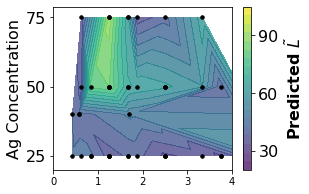

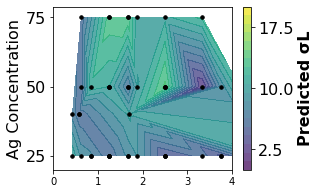

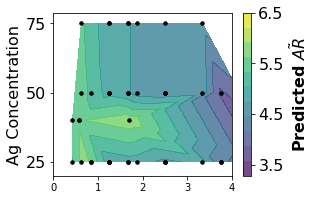

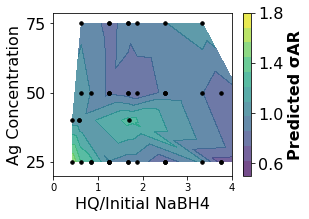

In [102]:
plt.rcParams['pdf.fonttype'] = 'truetype'
twod_synthesis_visualization(spectra_and_amounts, xaxis = 'Ag', yaxis = ['rNaBH4', 'tNaBH4'])

25 0.8333333333333334 62.170033145352825
25 3.75 32.1545512531701
75 3.3333333333333335 63.09282976342694
50 1.6666666666666667 54.391084093168274
50 1.25 82.7298466093374
25 3.75 32.522292637820115
50 1.25 46.27851266588479
50 1.6666666666666667 65.33962080587648
25 0.8333333333333334 43.39968634845556
50 1.25 41.22284706239368
25 0.625 44.14067221027828
40 0.425 42.34388086607788
25 0.4166666666666667 43.01715849222247
75 1.6666666666666667 46.68284774969788
75 1.25 89.14379084719782
50 3.75 39.252491411957166
75 1.6666666666666667 61.43495969608595
40 0.5666666666666667 45.260439071438455
50 0.8333333333333334 79.85230308289162
25 2.5 32.26423728905122
75 1.25 81.04446961839714
50 0.625 36.0421442474632
25 1.875 39.616326012978334
25 1.25 35.79487613388555
25 2.5 42.526608705516935
25 3.3333333333333335 35.98592916885538
40 0.5666666666666667 39.92640961863399
50 2.5 61.35951514026674
25 2.5 35.80743639806358
75 0.625 33.8725921104236
50 1.875 63.85967314713939
25 1.6666666666666667

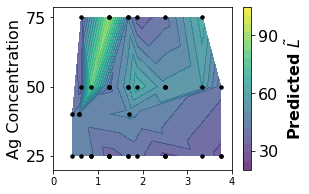

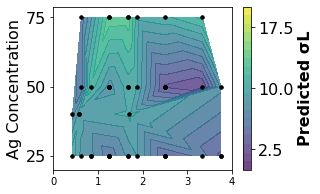

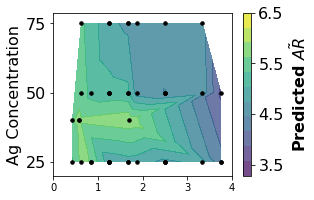

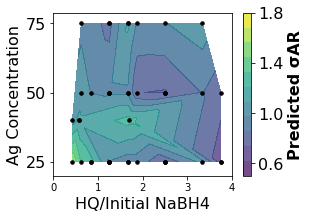

In [103]:
plt.rcParams['pdf.fonttype'] = 'truetype'
twod_synthesis_visualization(spectra_and_amounts_no_6, xaxis = 'Ag', yaxis = ['rNaBH4', 'tNaBH4'])